In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import sys
import pickle as pkl
from Signal import *
sys.path.append("../DetResponse/")
sys.path.append("../Utils/")
from Detector import *
from Plot_Histogram import *
from Signal import *

In [3]:
# Extract precompute spectra
pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_Charon_atEarth_nocut.pkl"
spectra = pkl.load(open(pathSpectra, "rb"))

# Precomputed Jfactor:
pathJfactor="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/JFactor_NFW.pkl"
Jfactor = pkl.load(open(pathJfactor, "rb"))

# print(spectra)
# print(Jfactor)

[]

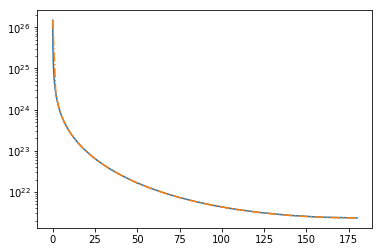

In [4]:
# Test the Spectra and Jfactor interpolation:

# First create desired bin:

psival = np.linspace(1e-3, 180, 100)

# Interpolate the Jfactor:
Jfactor_int = Interpolate_Jfactor(pathJfactor, psival)

# Plot original and interpolated Jfactor altogether:

plt.plot(Jfactor['psi'], Jfactor['J'], label='original')
plt.plot(psival, Jfactor_int, label='Interpolated', ls="-.", marker='')

plt.semilogy()
# plt.xscale('log')


[]

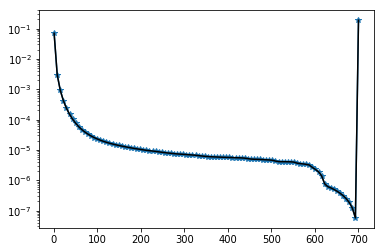

In [7]:
# Spectra interpolation:
# energy values:

Eval = np.linspace(1, 700, 100)

# channel and mass:
channel='nunu'
mass=700

# Interpolate the spectra:
Spectra_int = Interpolate_Spectra(pathSpectra, Eval, channel, mass)

# Plot for comparison:
# color code:
colors = {'nu_e':'red', 'nu_mu':'blue', 'nu_tau':'green'}
plt.plot(Eval, Spectra_int['nu_e'], marker='*')
# plt.plot(Eval, Spectra_int['nu_e_bar'], ls='-.')
#Energy
spectra_E = np.array(spectra[channel][str(mass)]['nu_e']["E"])
#Spectra
spectra_dNdE = np.array(spectra[channel][str(mass)]['nu_e']["dNdE"])
plt.plot(spectra_E, spectra_dNdE, color='black')
plt.semilogy()
# plt.xscale('log')
# plt.xlim(0, 30)

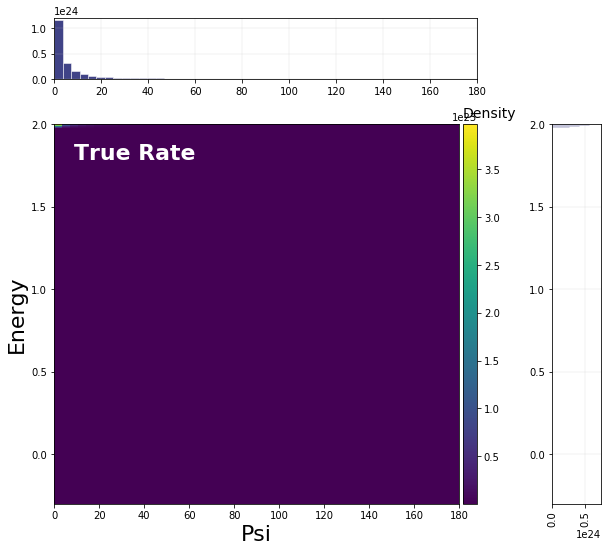

In [8]:
# Define set up for the analysis:

# mass and channel:
# channel and mass:
channel='nunu'
mass=100

# Define binning:
Eval = np.linspace(1, mass, 100)
Ewidth = (mass-1)/(100-1)
Eedges = [E - Ewidth/2. for E in Eval]
Eedges.append(Eval[-1] + Ewidth/2.)

Psiedges = np.linspace(0, 180, 51)
Psiwidth = 180./50.
Psival = [Psiedges[i]+Psiwidth/2. for i in range(len(Psiedges)-1)]

# Extract true rate:
# Jfactor:
Jfactor = Interpolate_Jfactor(pathJfactor, Psival)
# Spectra:
Spectra = Interpolate_Spectra(pathSpectra, Eval, channel, mass)

# print(Eval)
# print(Eedges)
# print(Psival)
# print(Psiedges)


# Compute the rate as Spectra x Jfactor
Rate = TrueRate(Spectra, Jfactor)

# Rate
plot_projections(Rate['nu_e'], [np.array(Psiedges), np.log10(np.array(Eedges))], "Psi", "Energy", "True Rate")


In [9]:
# Compute detected event using a precomputed response matrix:
Resp = pkl.load(open("/data/user/tchau/Sandbox/GC_OscNext/DetResponse/PreComp/ResponseMatrix_mass_100.pkl", "rb"))

Detected = DetectedRate_withRespMatrix(Rate, Resp)
# Detected[PID][psiReco][Ereco]
Detected.shape

(3, 18, 50)

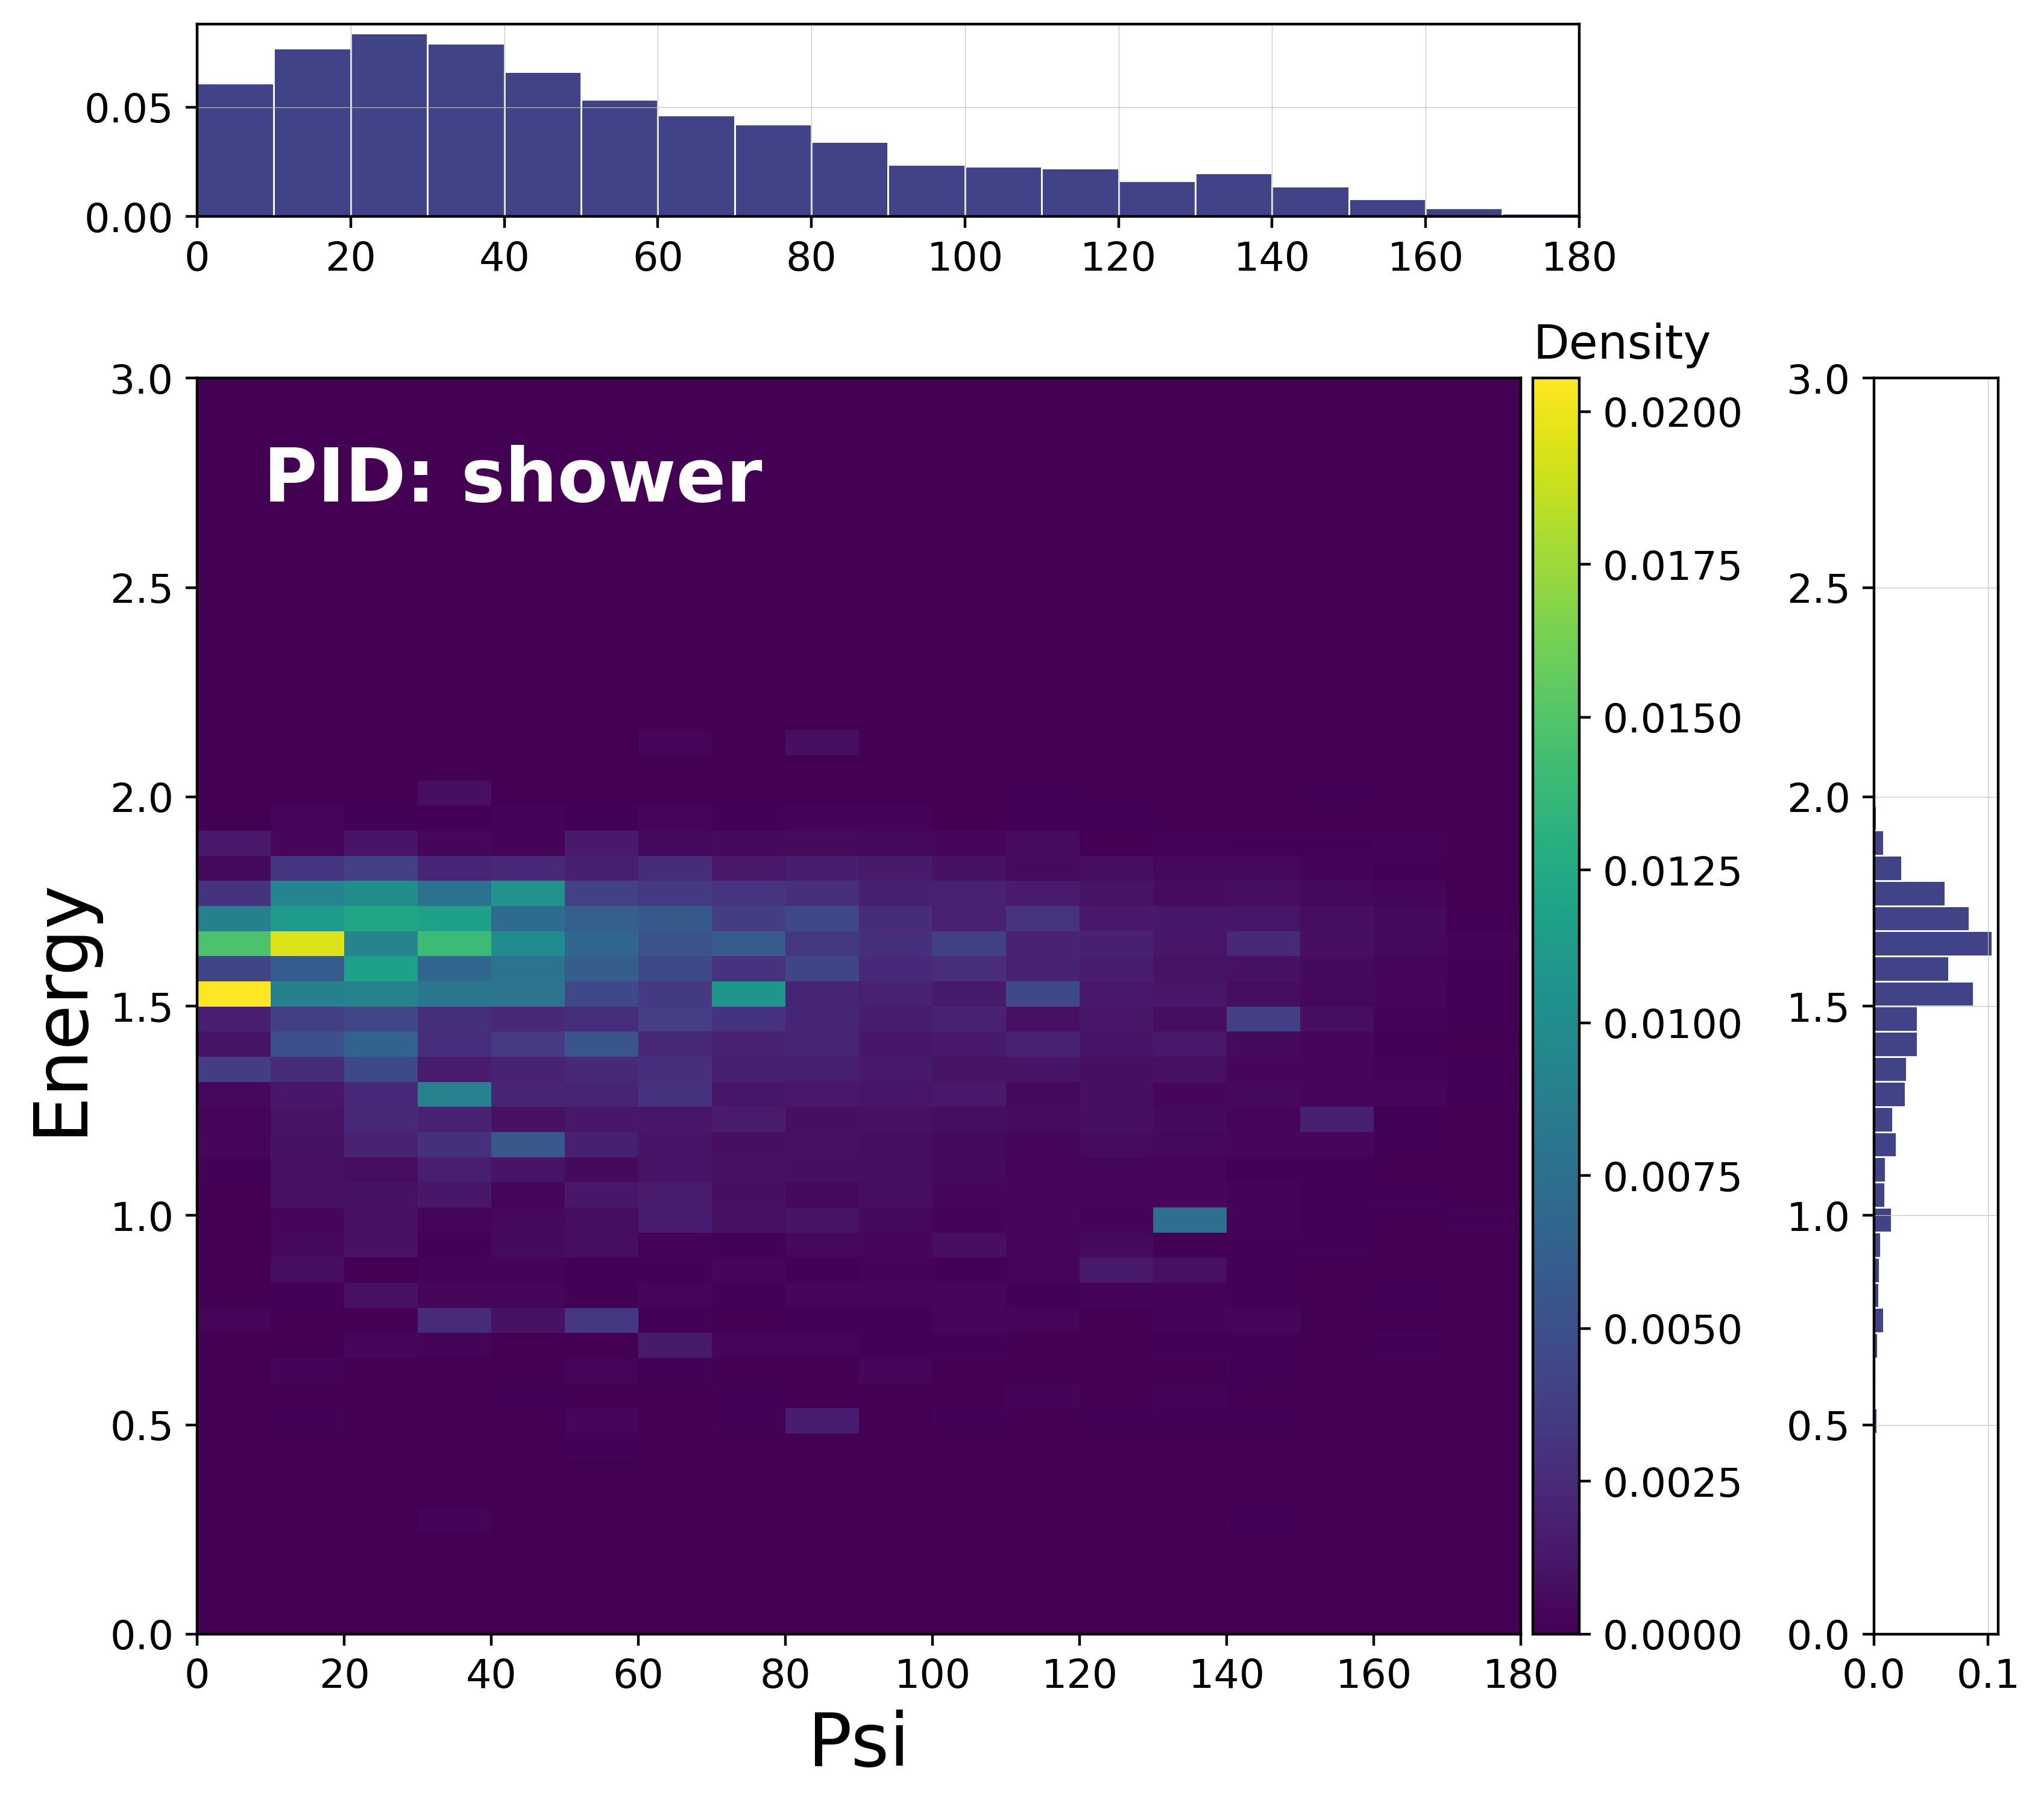

In [71]:
#Change the resolution of the plots
mpl.rcParams['figure.dpi']= 400
# Plot reco event distribution:
plot_projections(Detected[0], [np.array(Resp['Bin']['reco_psi_edges']), np.array(np.log10(Resp['Bin']['reco_energy_edges']))], "Psi", "Energy", "PID: shower")


Event by Event PDF (no KDE)

In [8]:
MCdict = ExtractMC()
Detected_evtbyevt = DetectedRate_evtbyevt(MCdict, pathSpectra, pathJfactor, channel, mass, Resp['Bin'])

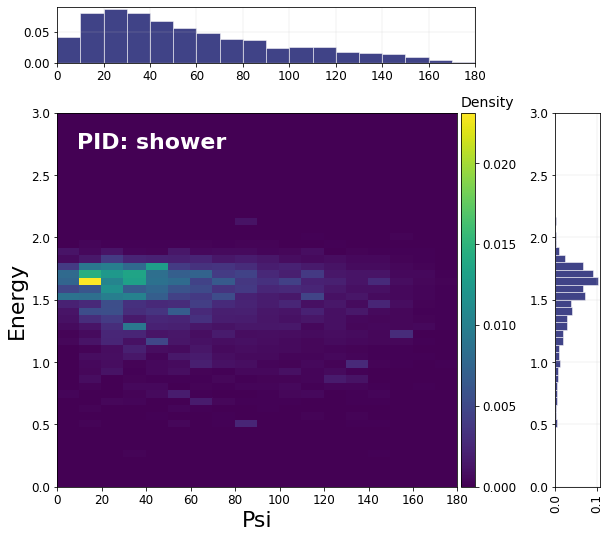

In [9]:
plot_projections(Detected_evtbyevt[0], [np.array(Resp['Bin']['reco_psi_edges']), np.array(np.log10(Resp['Bin']['reco_energy_edges']))], "Psi", "Energy", "PID: shower")


/var/folders/v4/4lt7t62s39z5v7kv83wk_b440000gn/T/ipykernel_1866/2609828597.py:4: RuntimeWarning: invalid value encountered in true_divide
  chi2 = (H1-H2)*(H1-H2)/np.sqrt(H2)


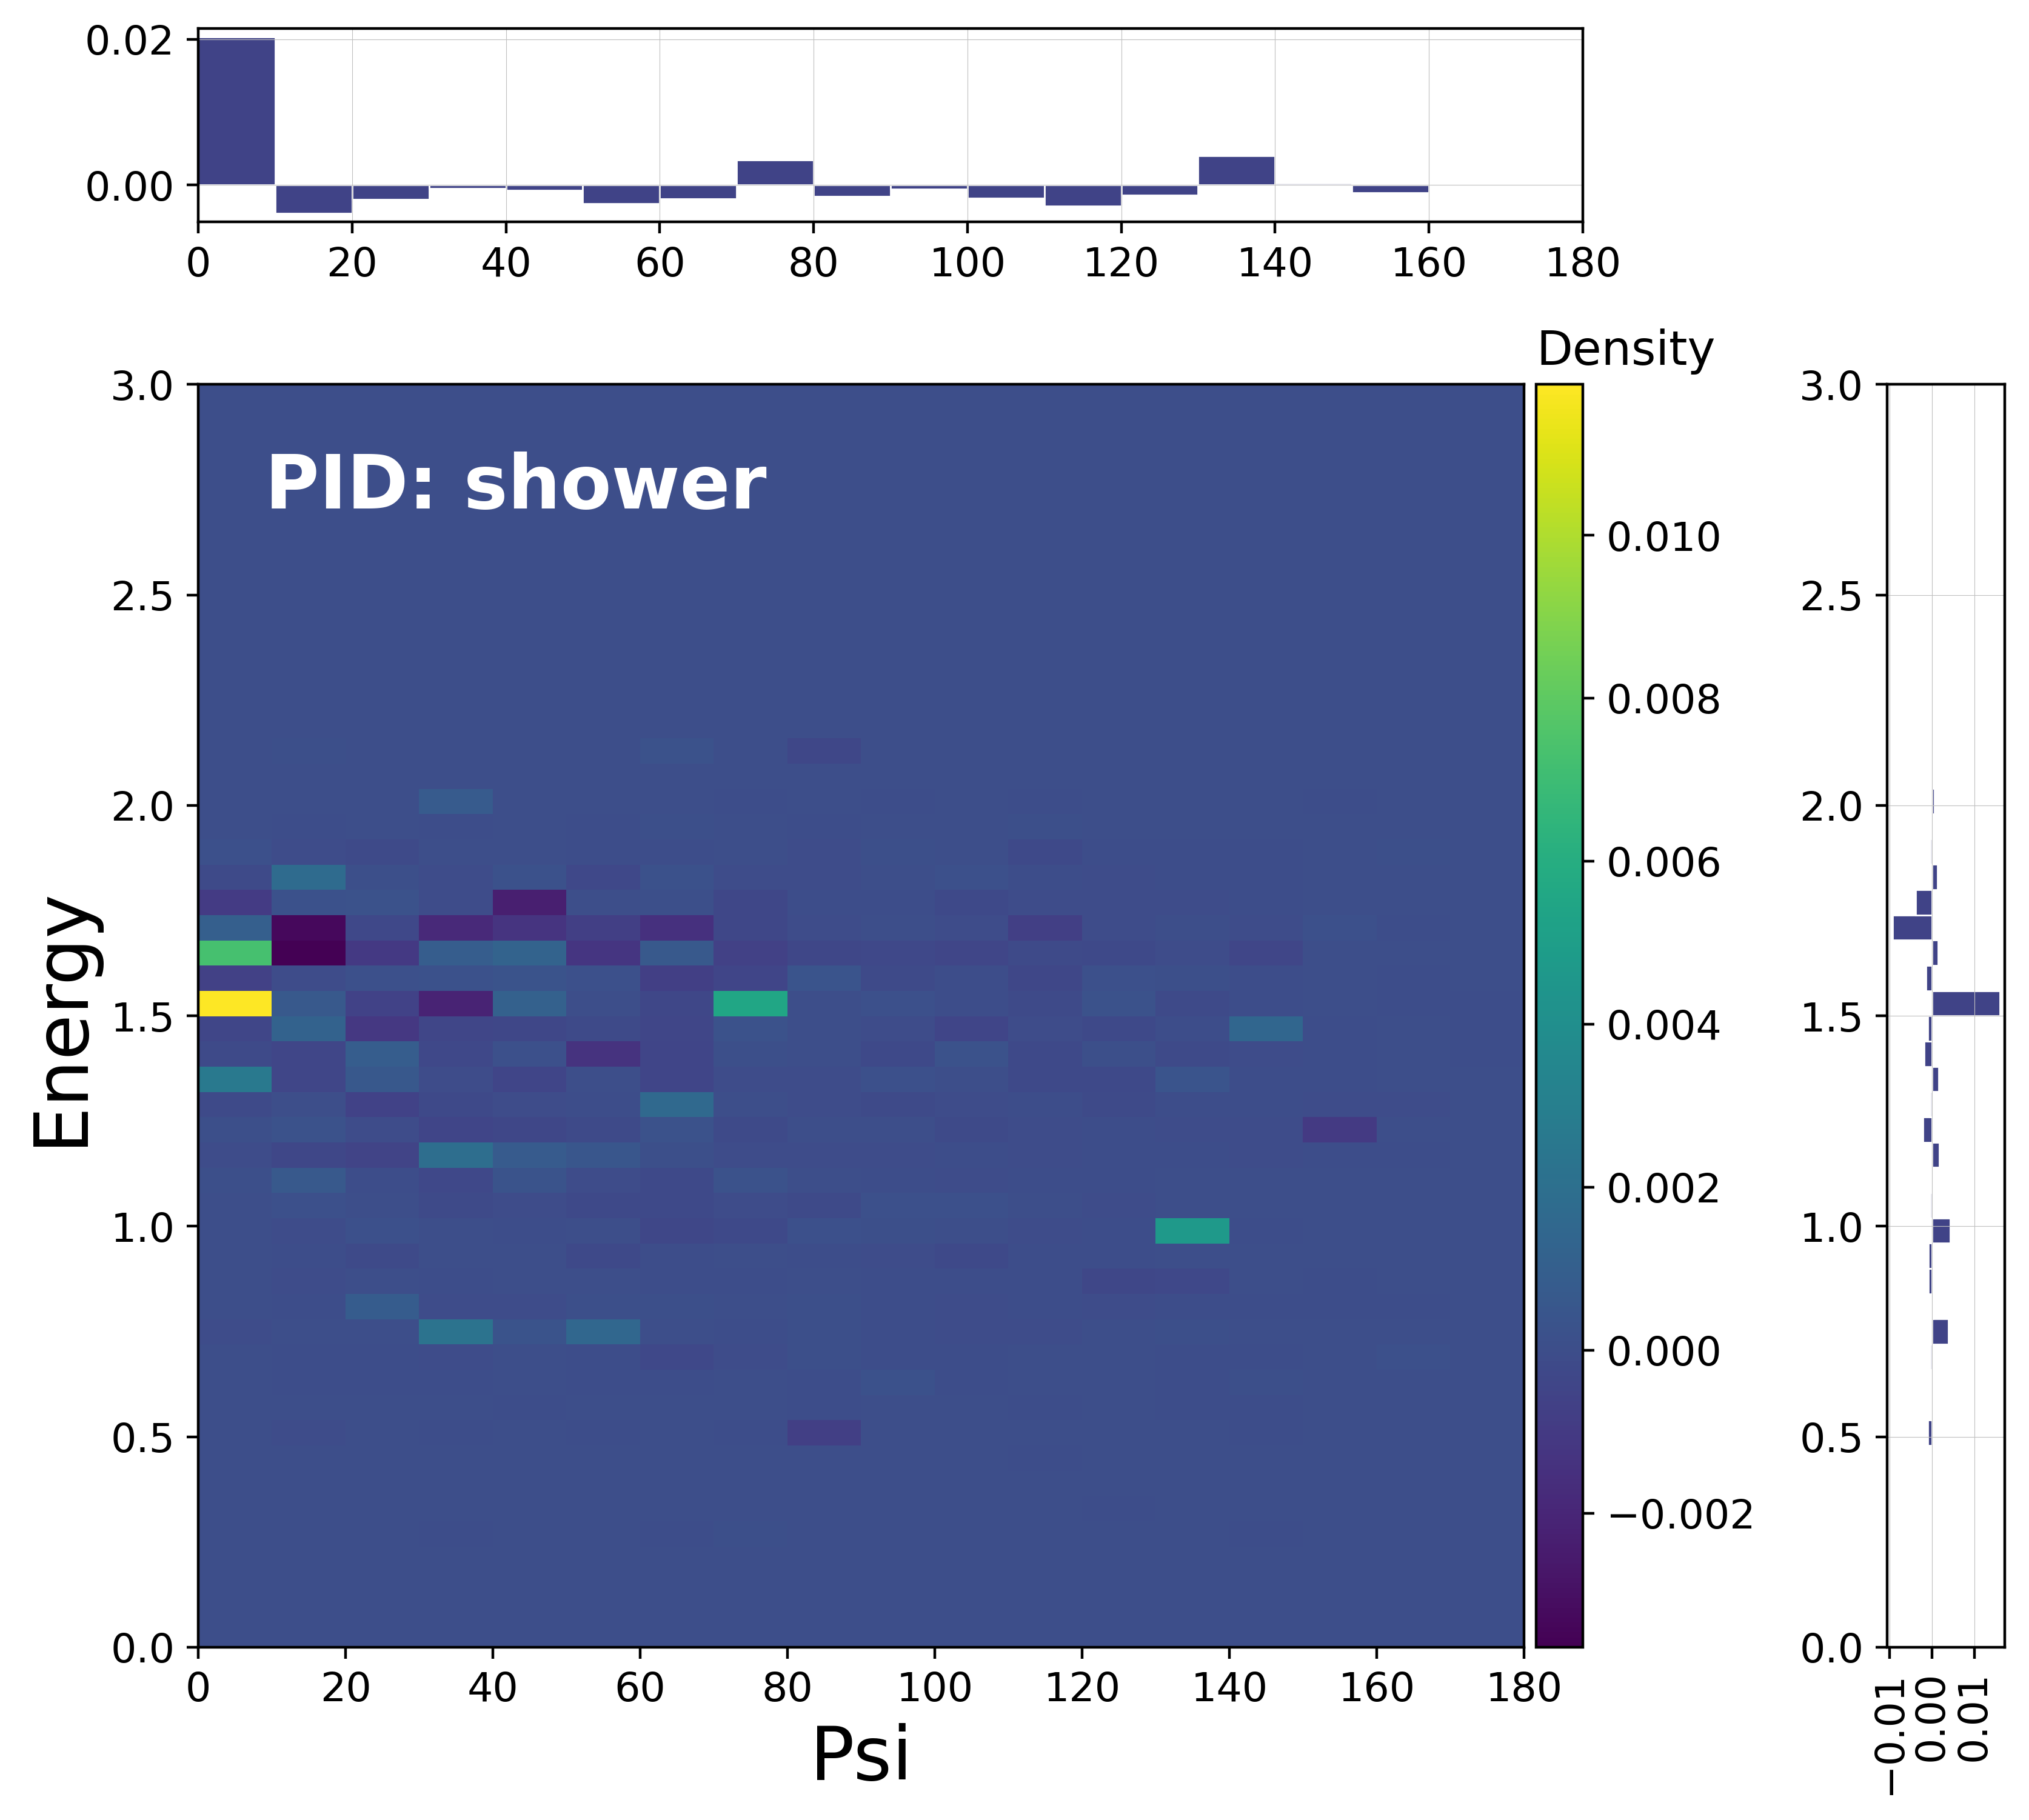

In [83]:
H1 = Detected_evtbyevt[0]
H2 = Detected[0]

chi2 = (H1-H2)*(H1-H2)/np.sqrt(H2)
diff = H2-H1
plot_projections(diff, [np.array(Resp['Bin']['reco_psi_edges']), np.array(np.log10(Resp['Bin']['reco_energy_edges']))], "Psi", "Energy", "PID: shower")


Comparison for each mass values -
Evt-by-Evt vs Response Matrix

In [33]:
# mass list:

masses = [6, 10, 30, 50, 70, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Define channel:
channel = 'nunu'

# compute evt distribution for every mass:
# Path to precomputed spectra, Jfactor
pathSpectra="../Spectra/PreComp/Spectra_ann_Charon_atEarth_nocut.pkl"
pathJfactor="../Spectra/PreComp/JFactor_NFW.pkl"

PDF = dict()

for mass in masses:
    # Extract response matrix:
    Resp = pkl.load(open("../DetResponse/PreComp/ResponseMatrix_mass_{}.pkl".format(mass), "rb"))
    PDF[mass] = dict()
    # Compute evt-by-evt PDF
    PDF[mass]["evt"] = DetectedRate_evtbyevt(MCdict, pathSpectra, pathJfactor, channel, mass, Resp['Bin'])
    PDF[mass]["resp"] = DetectedRate_allstep(pathSpectra, pathJfactor, channel, mass)
    

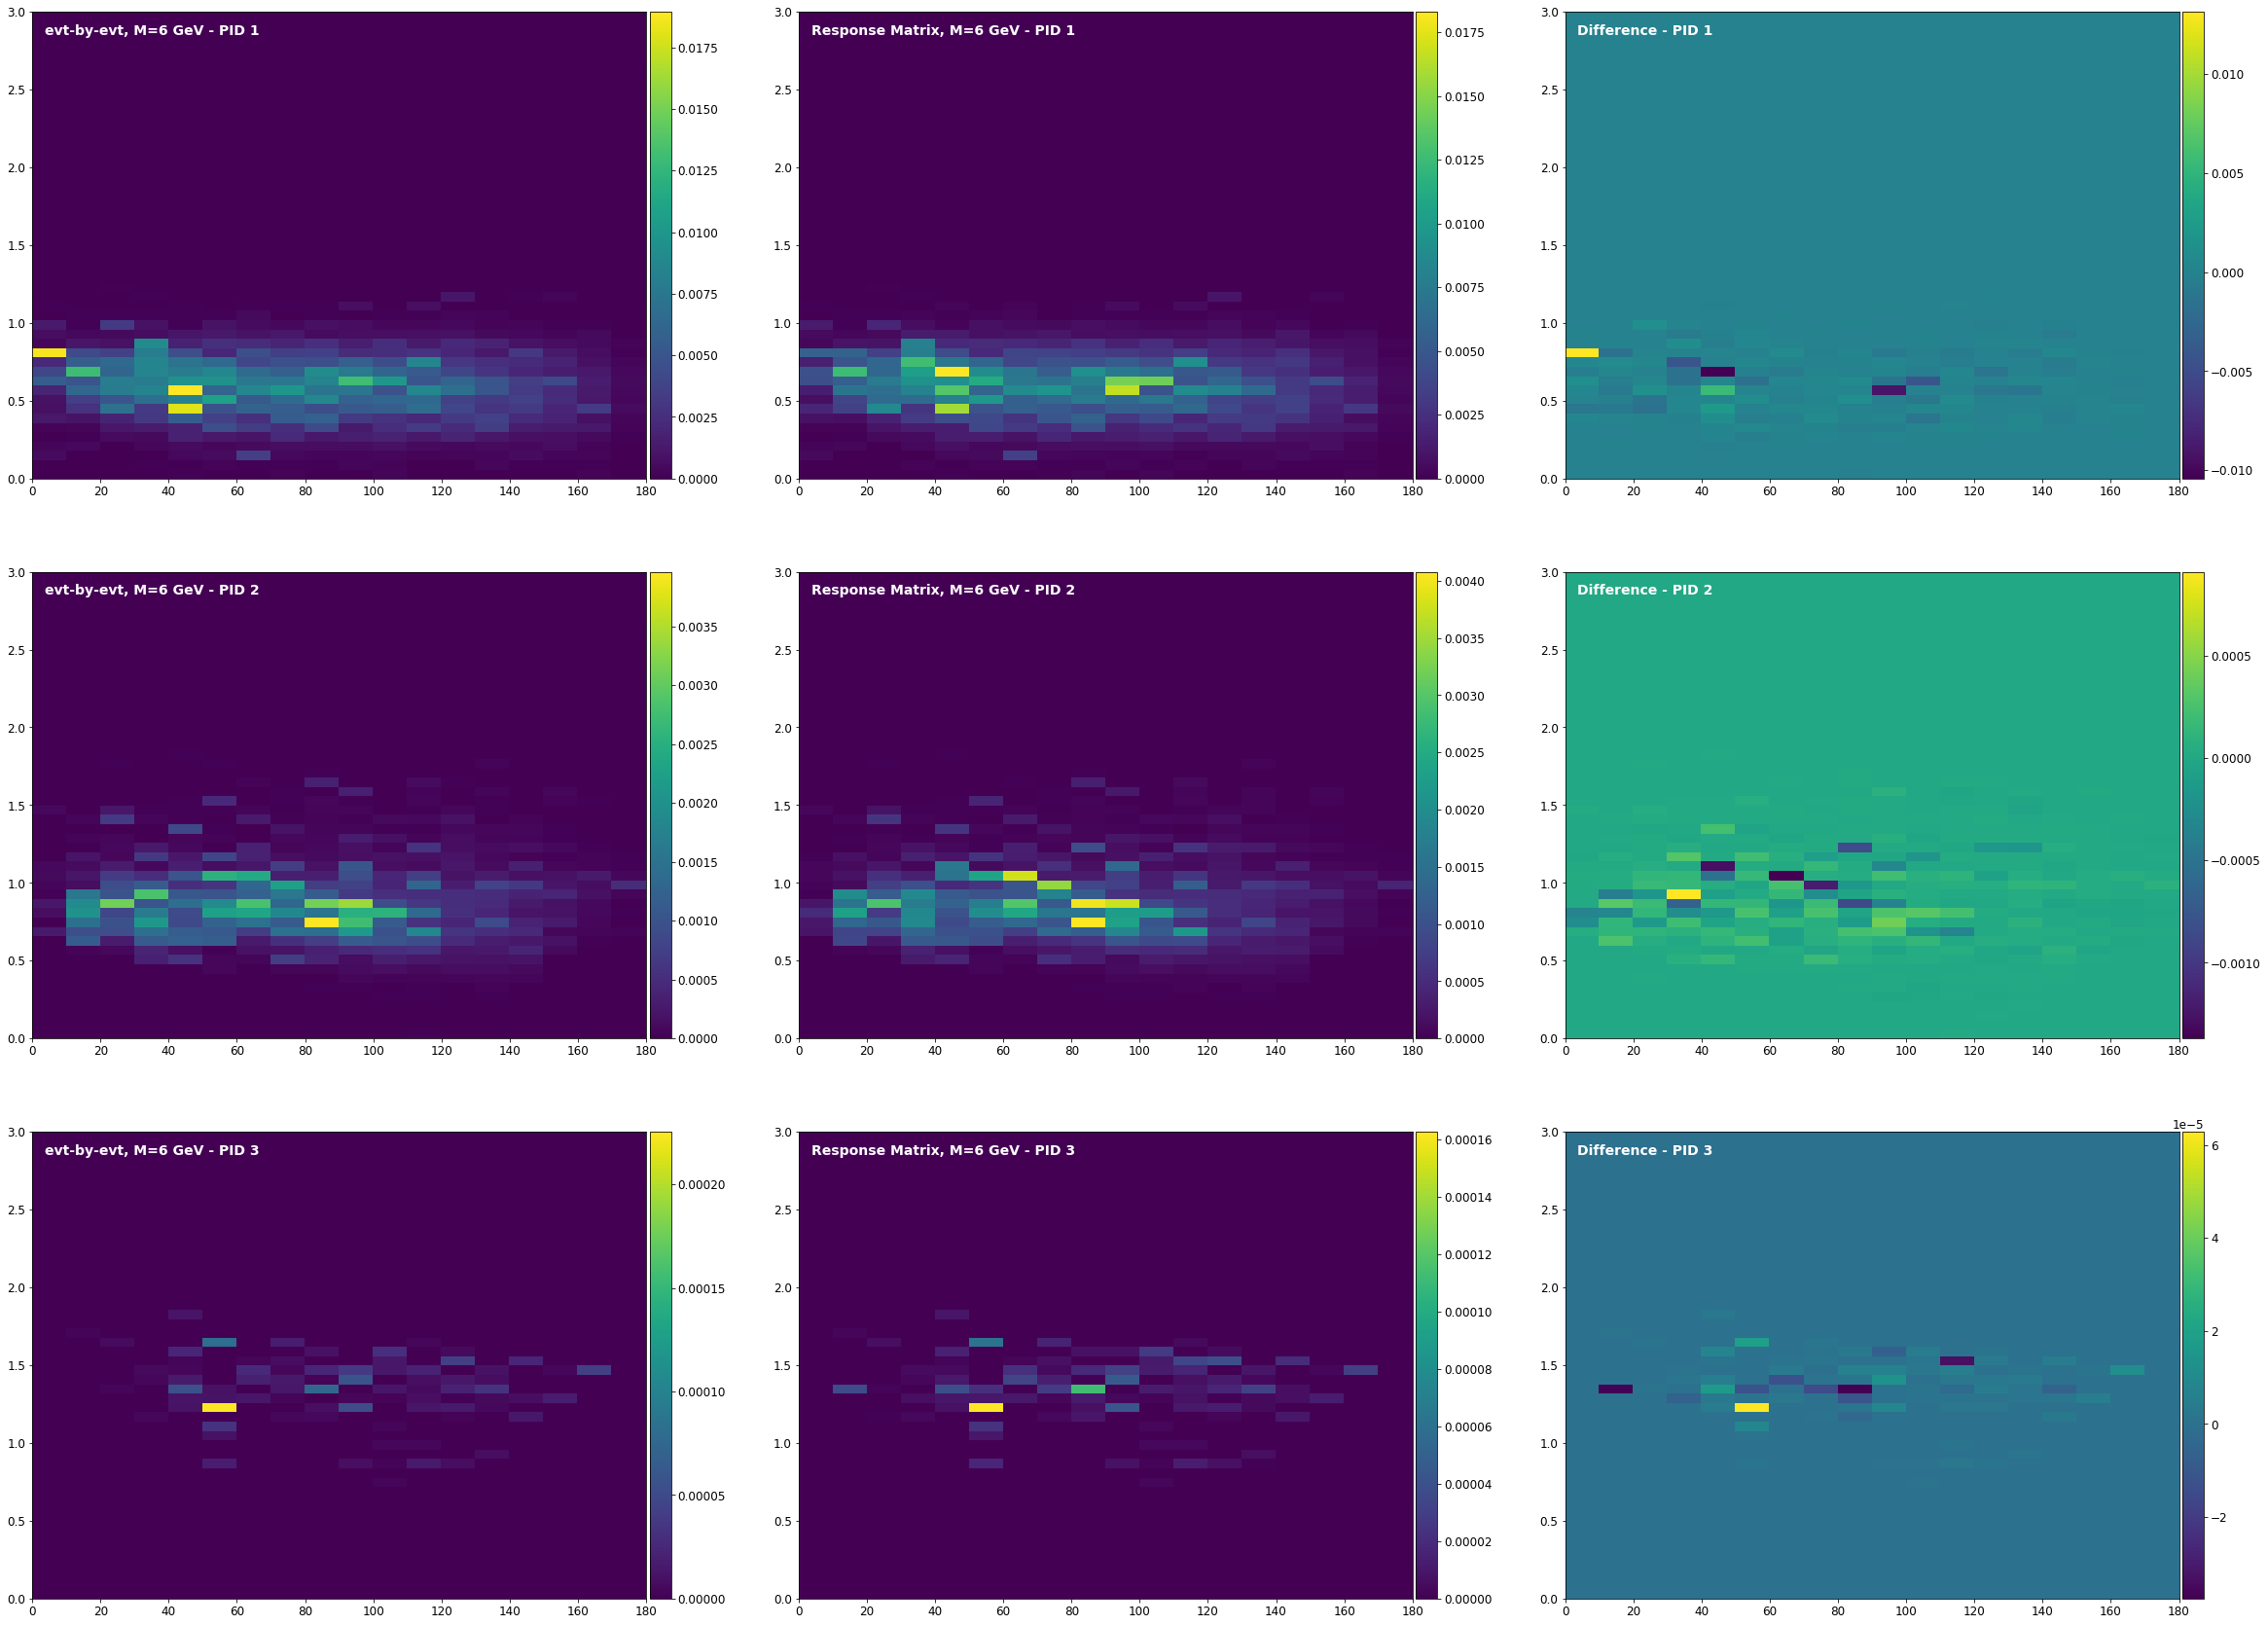

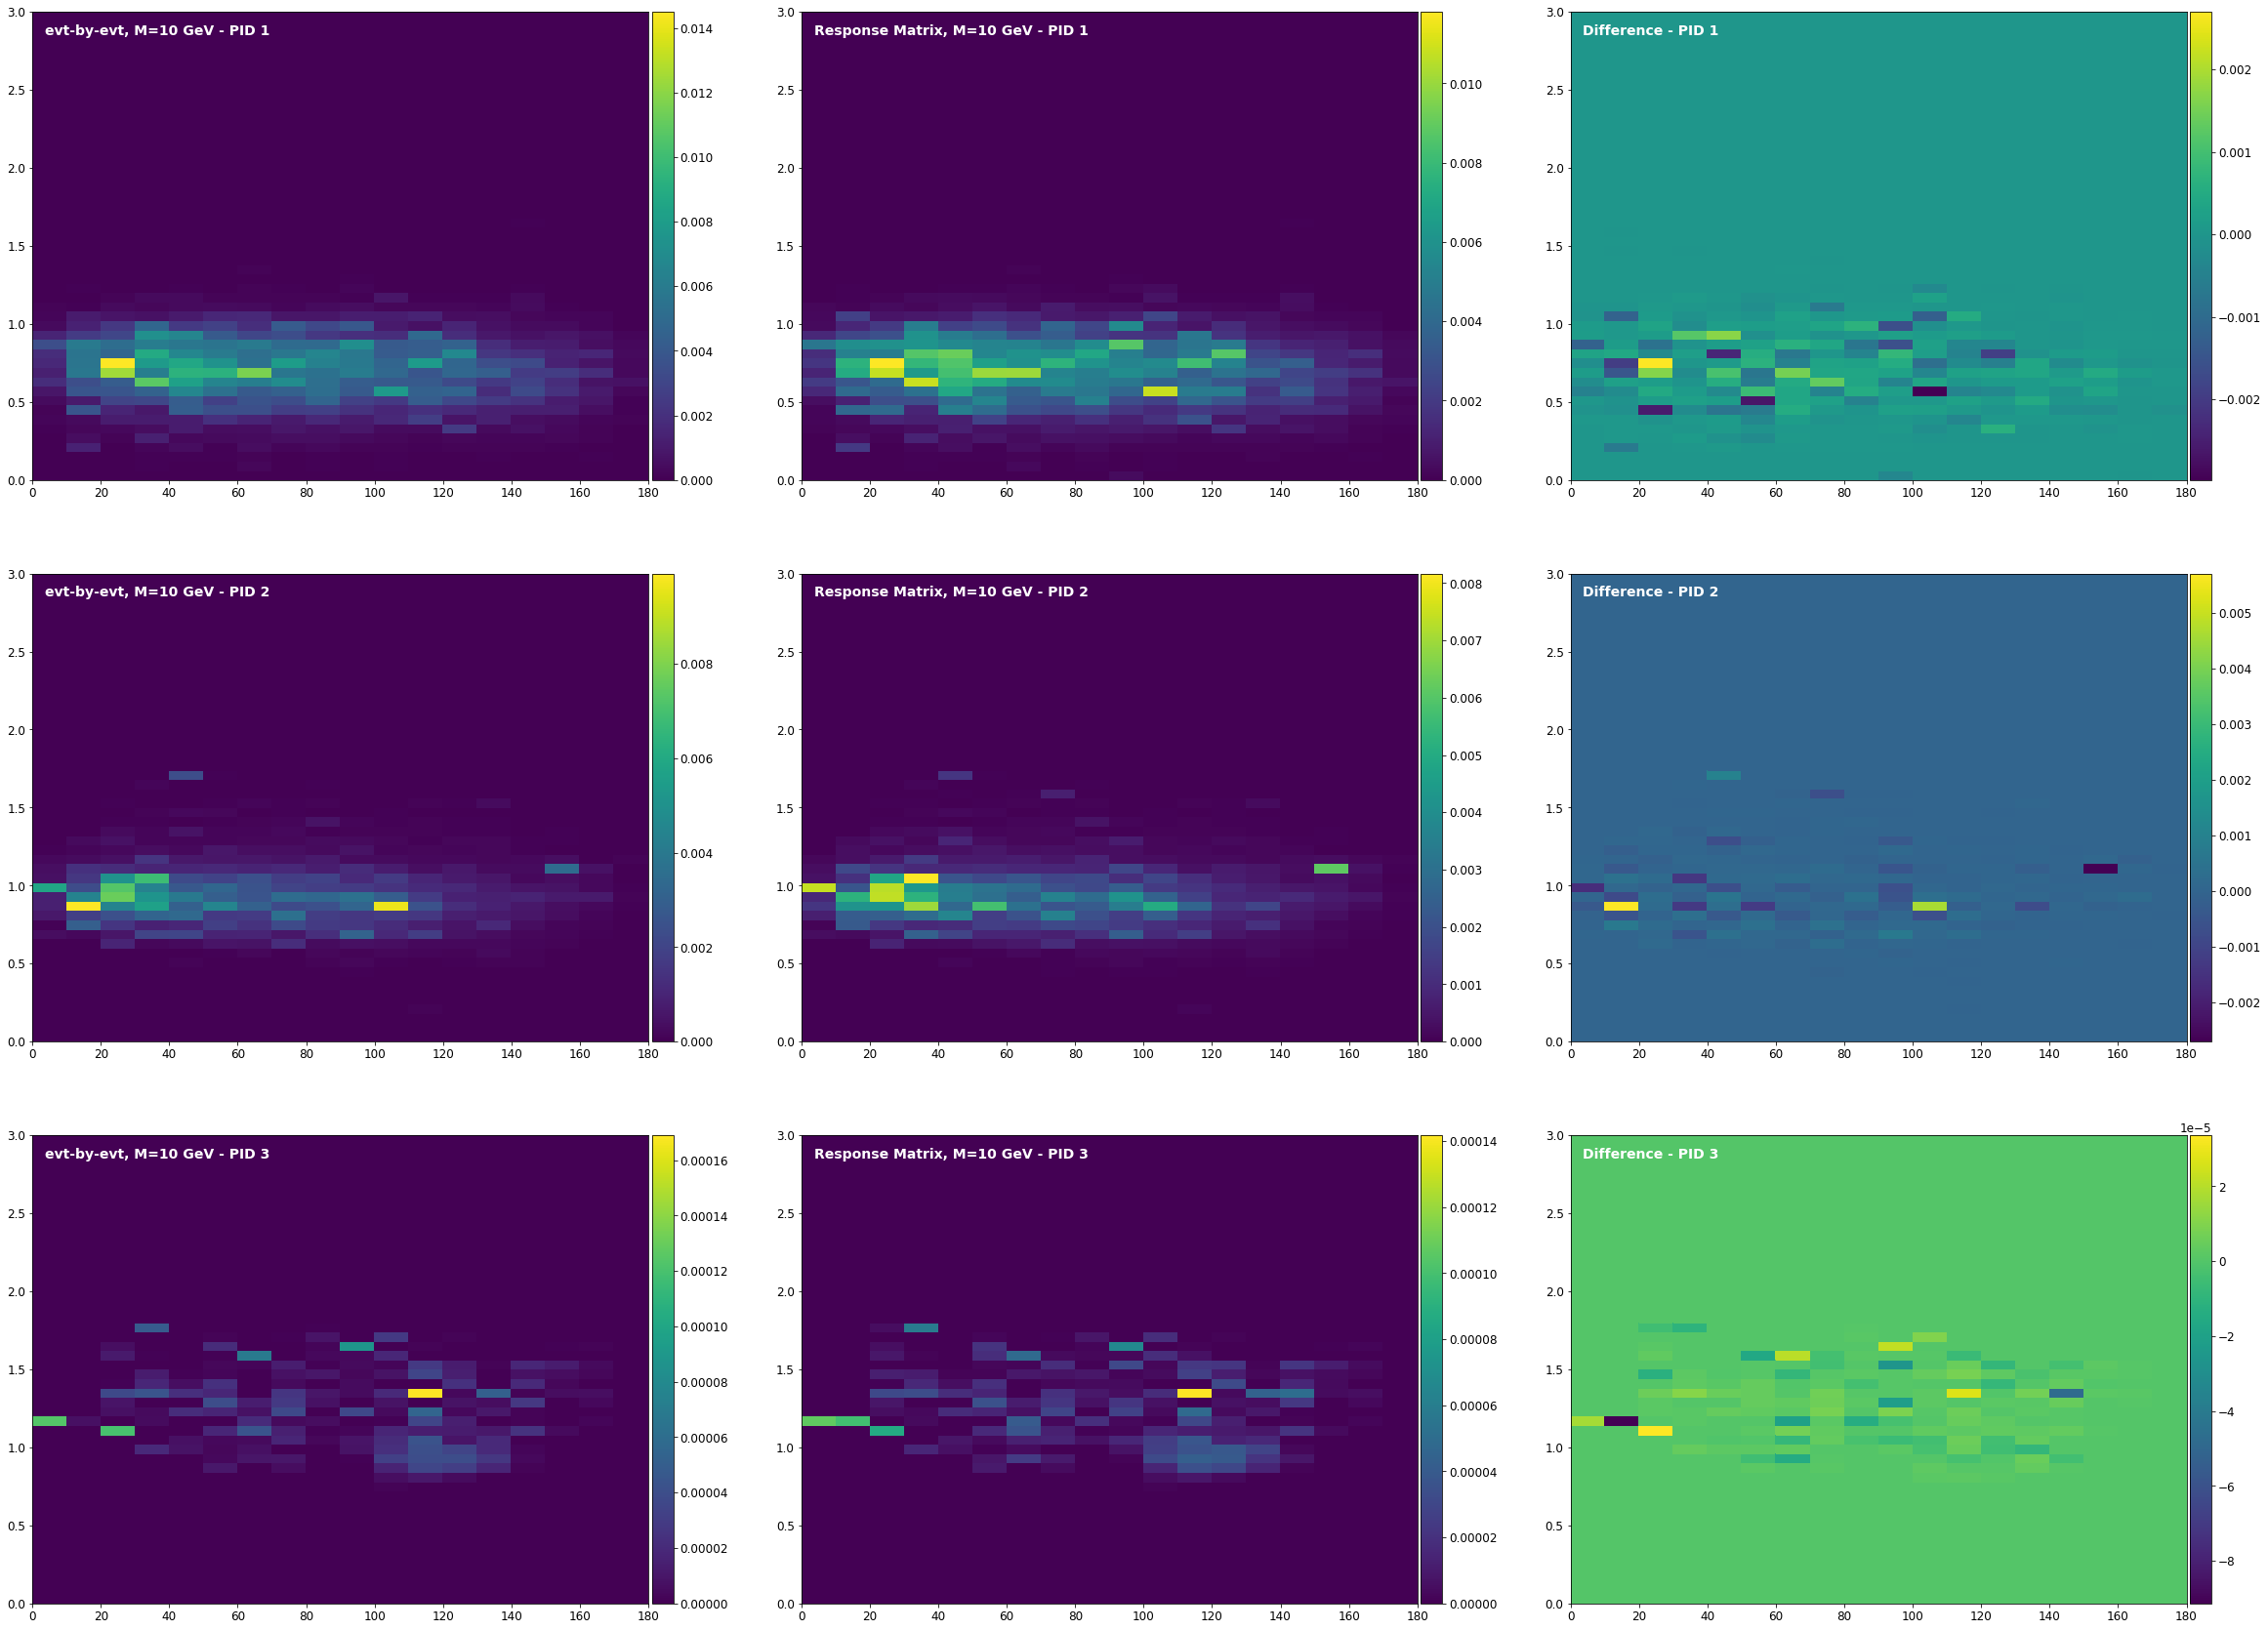

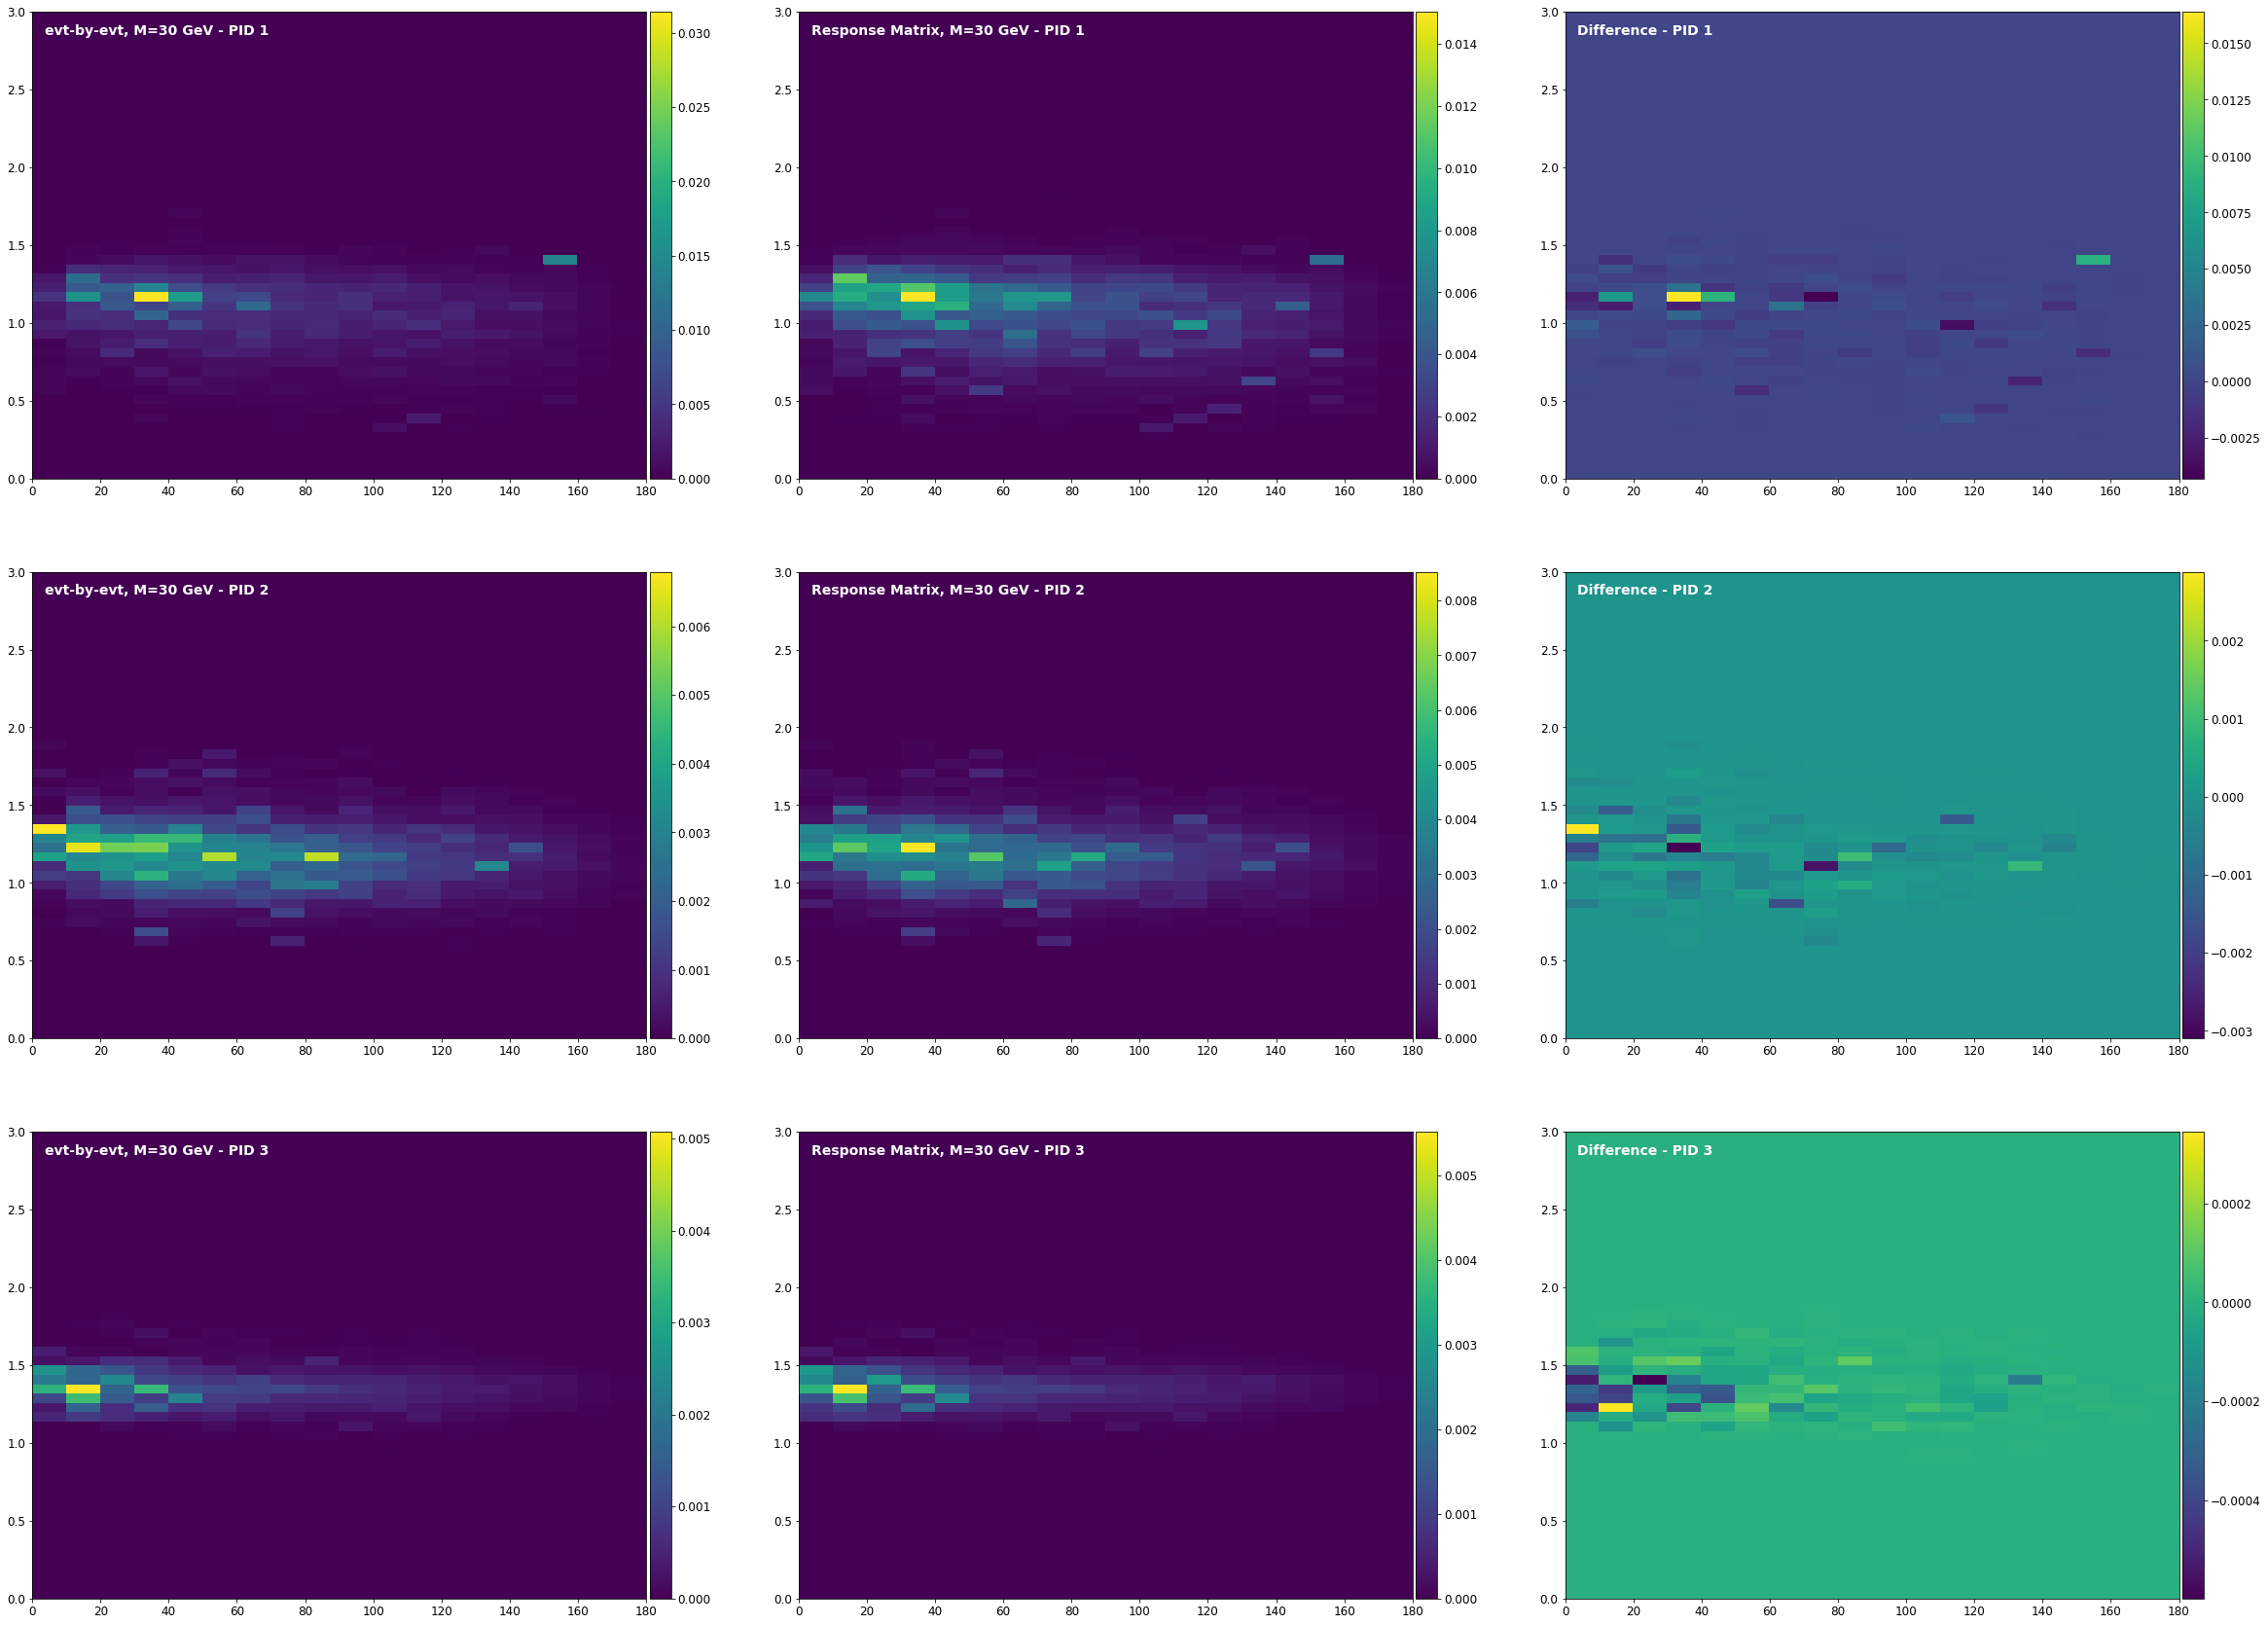

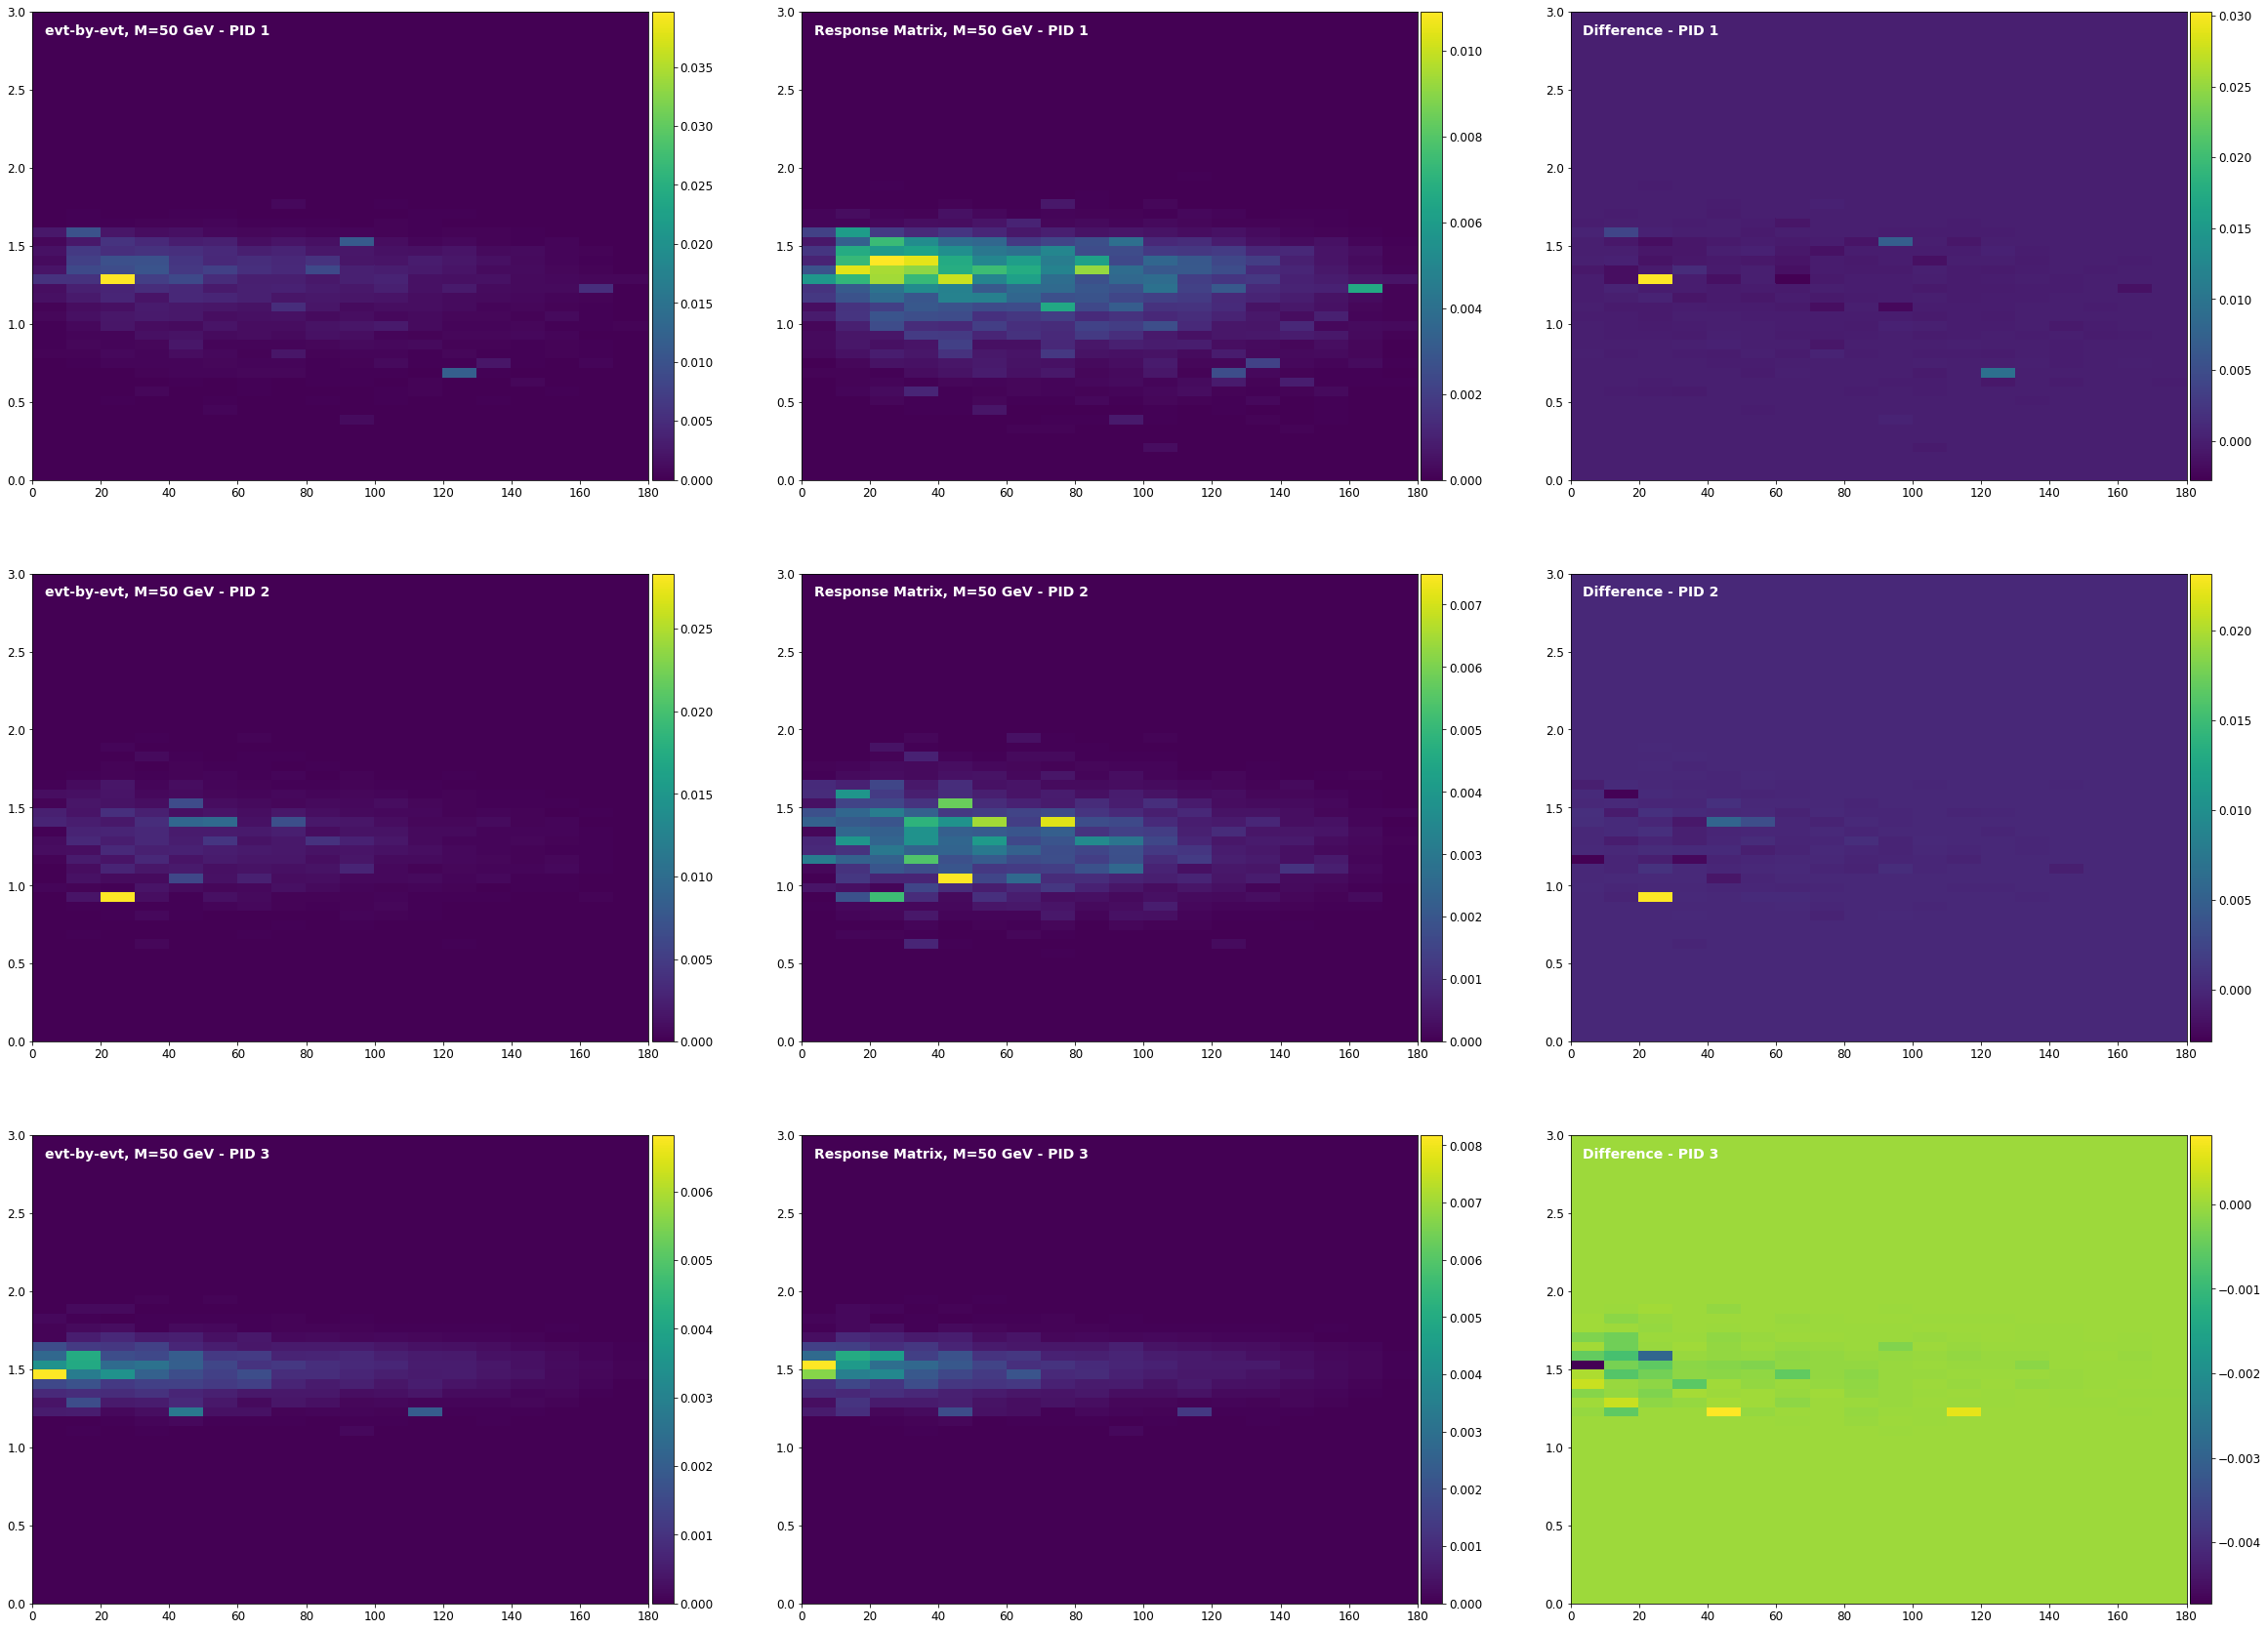

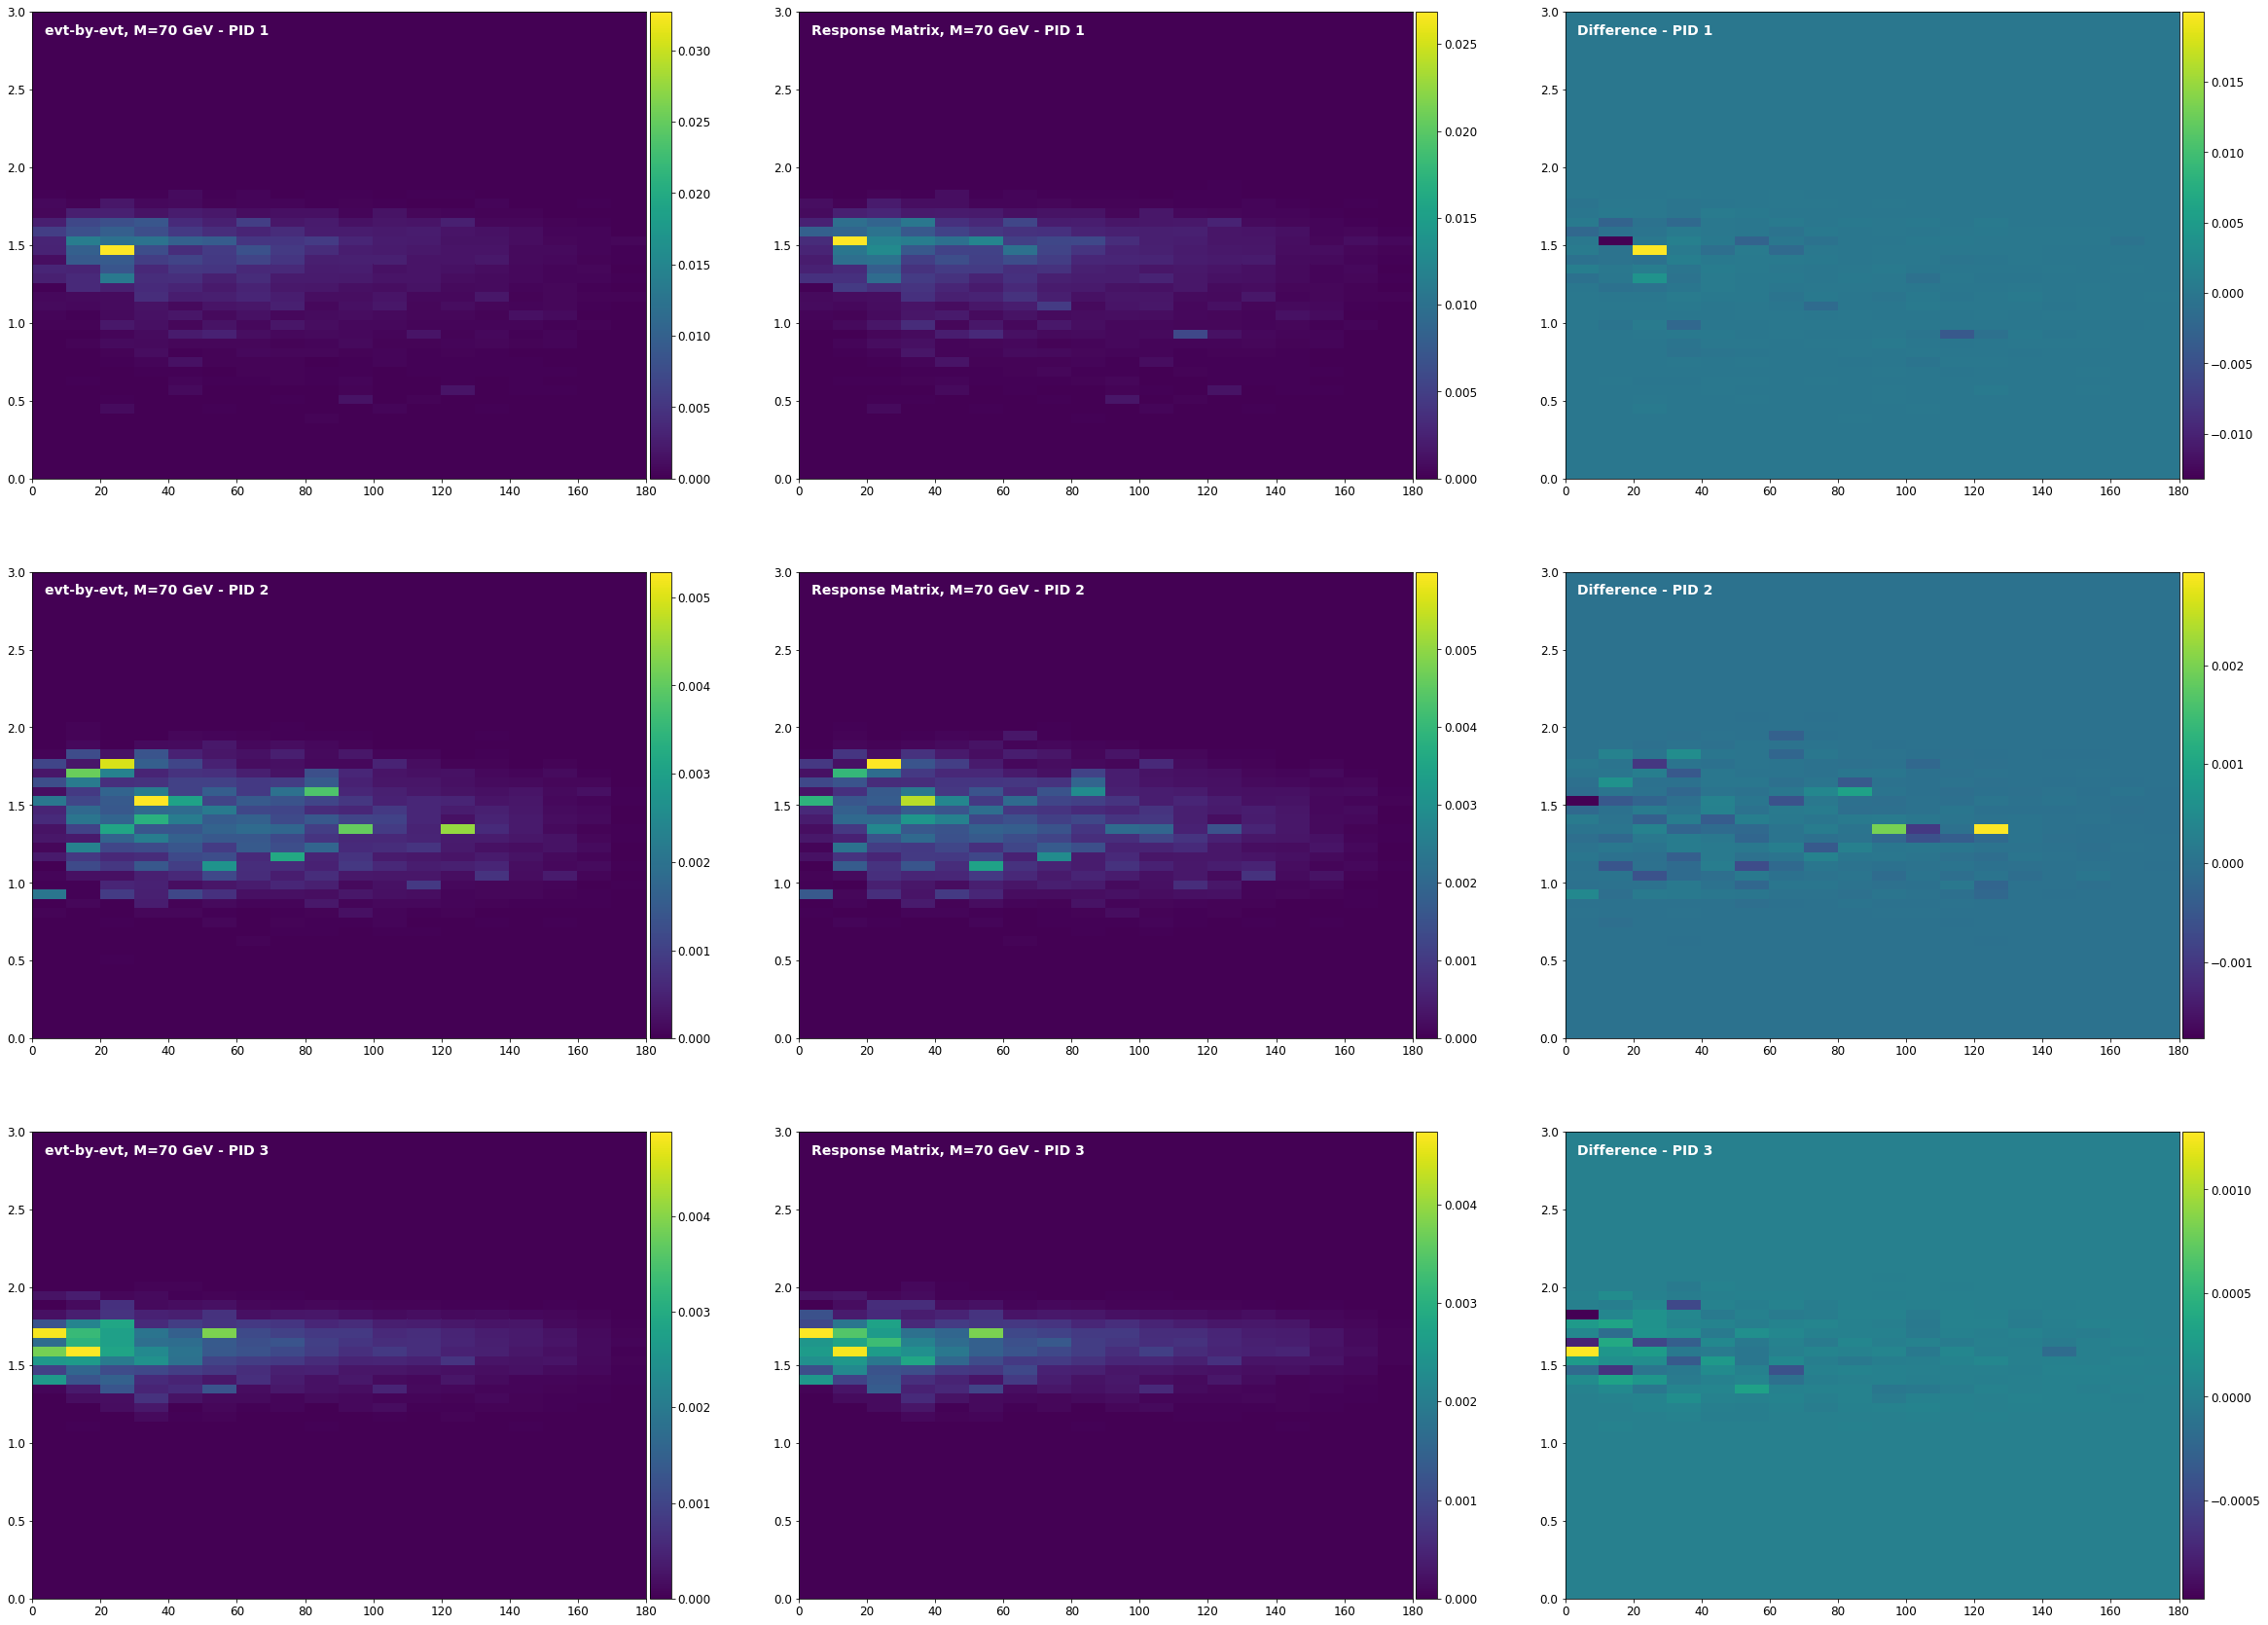

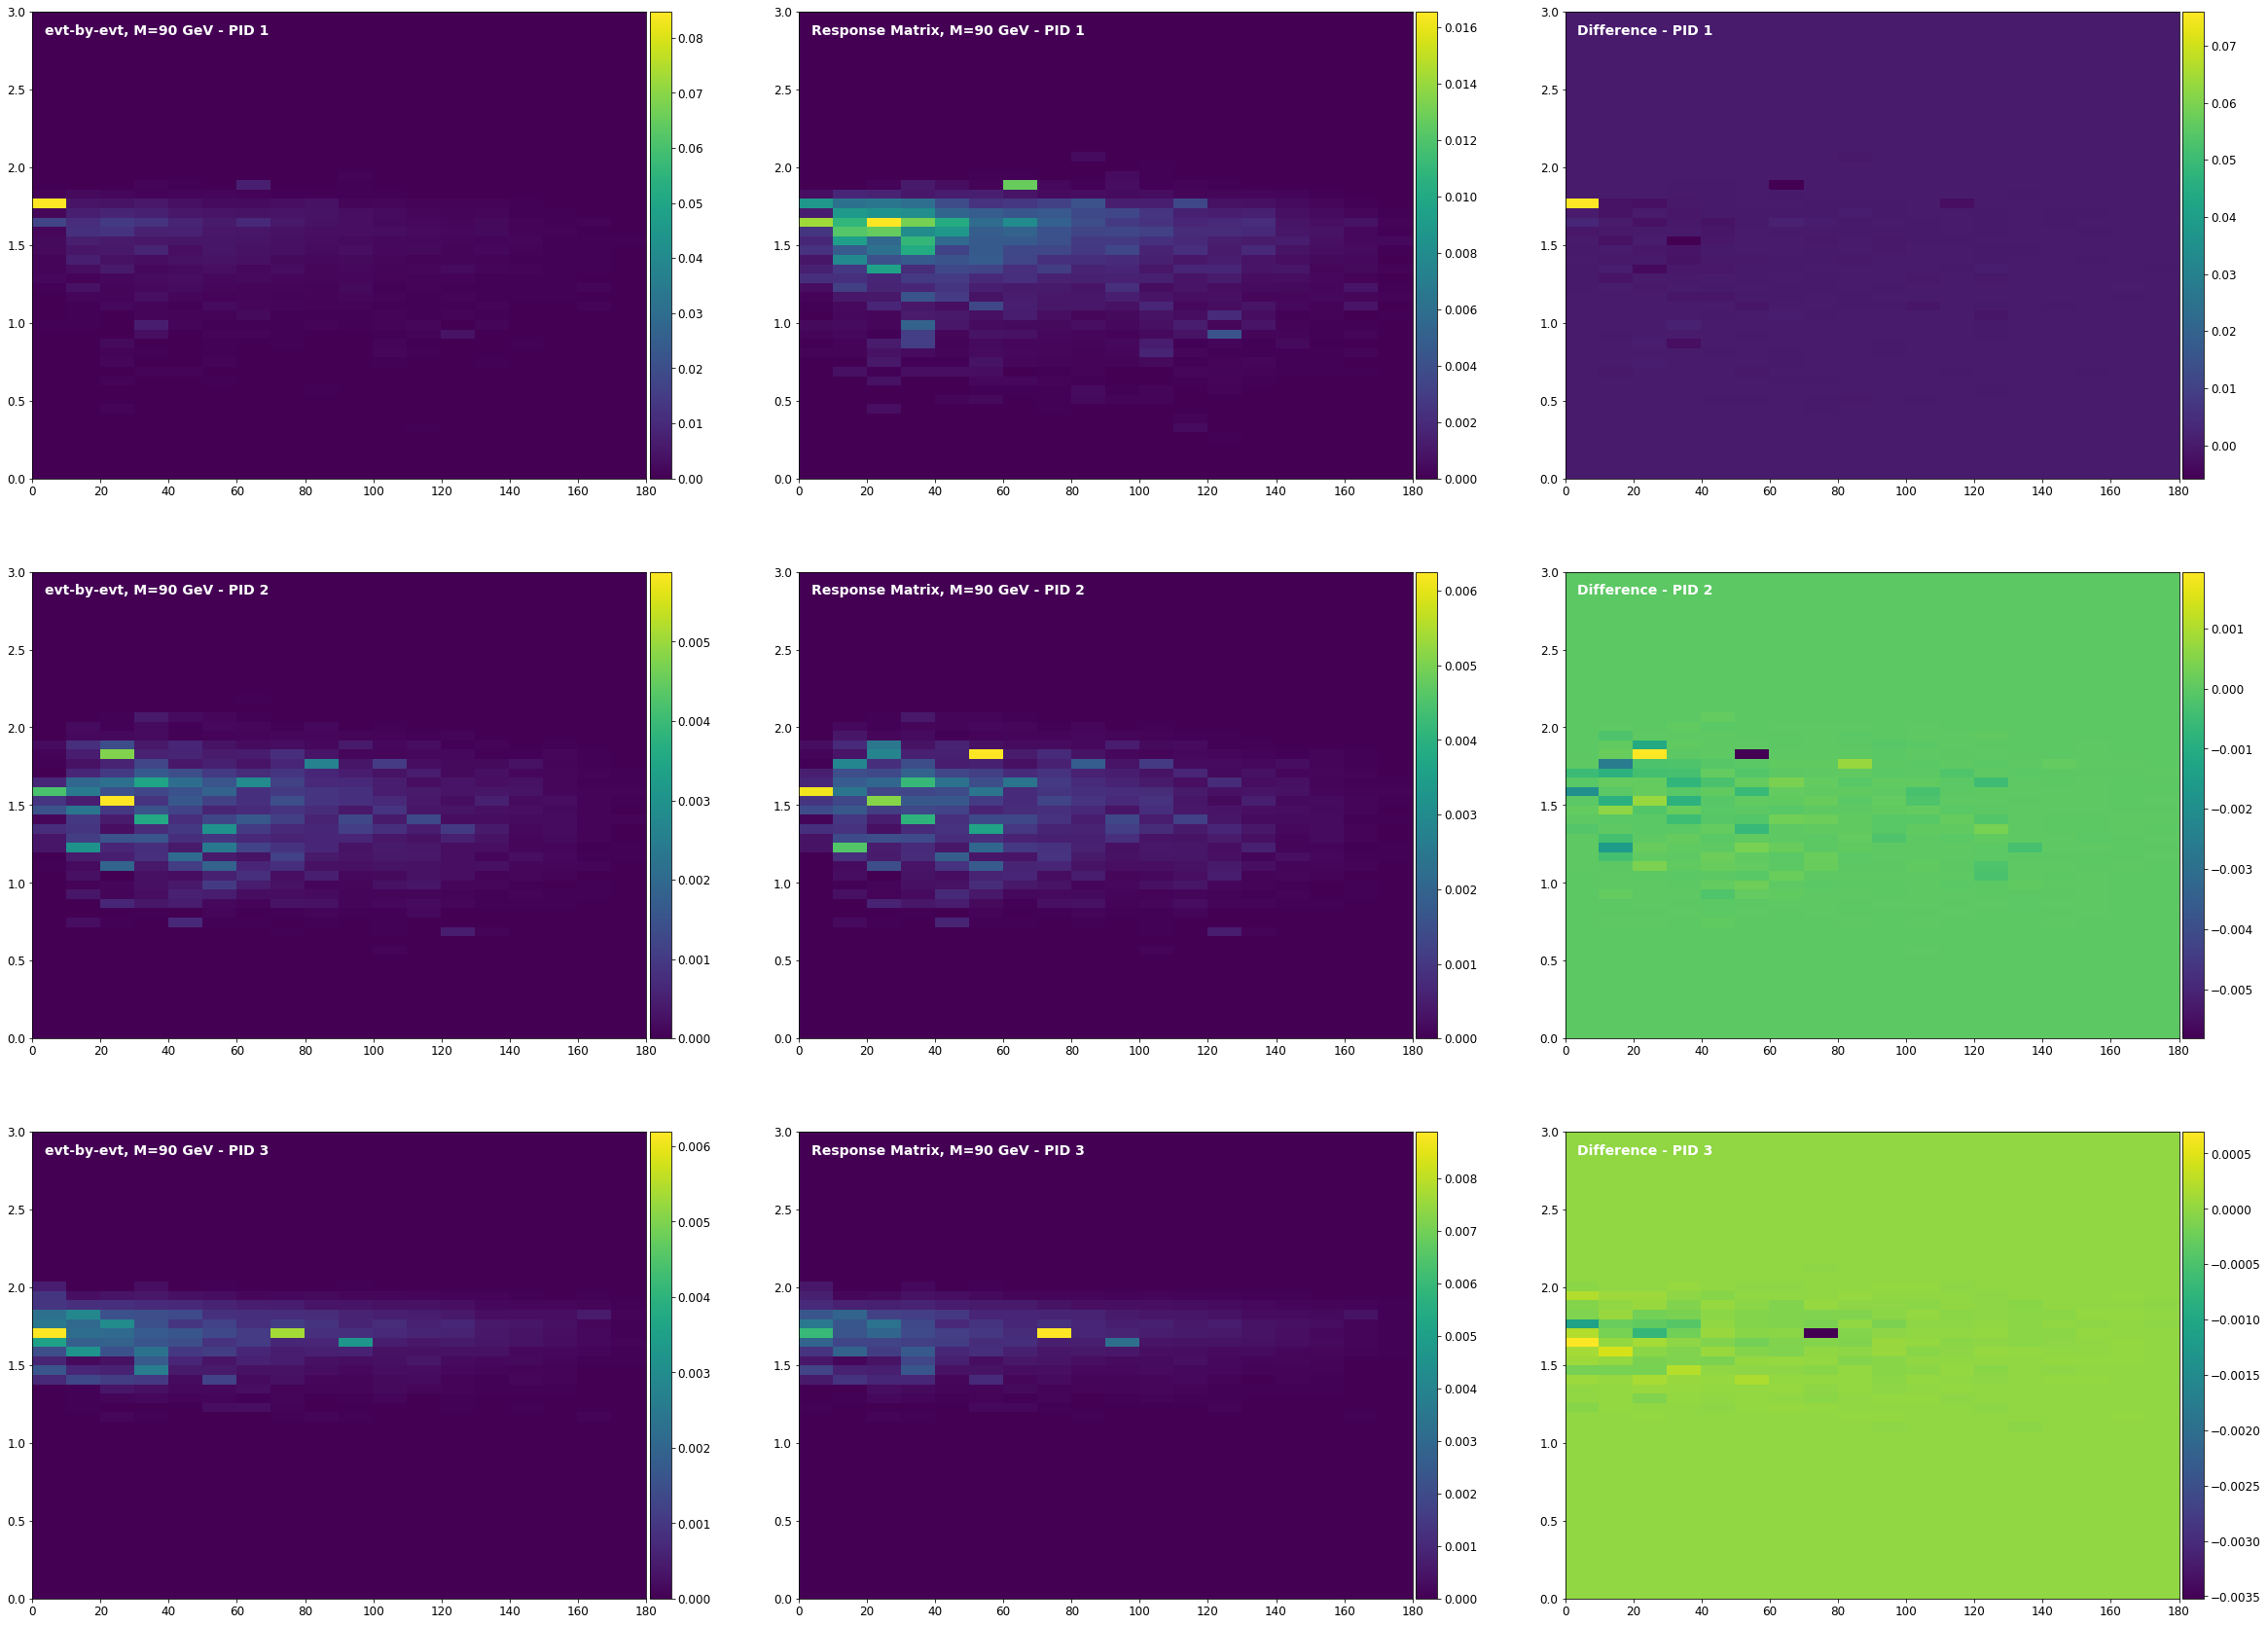

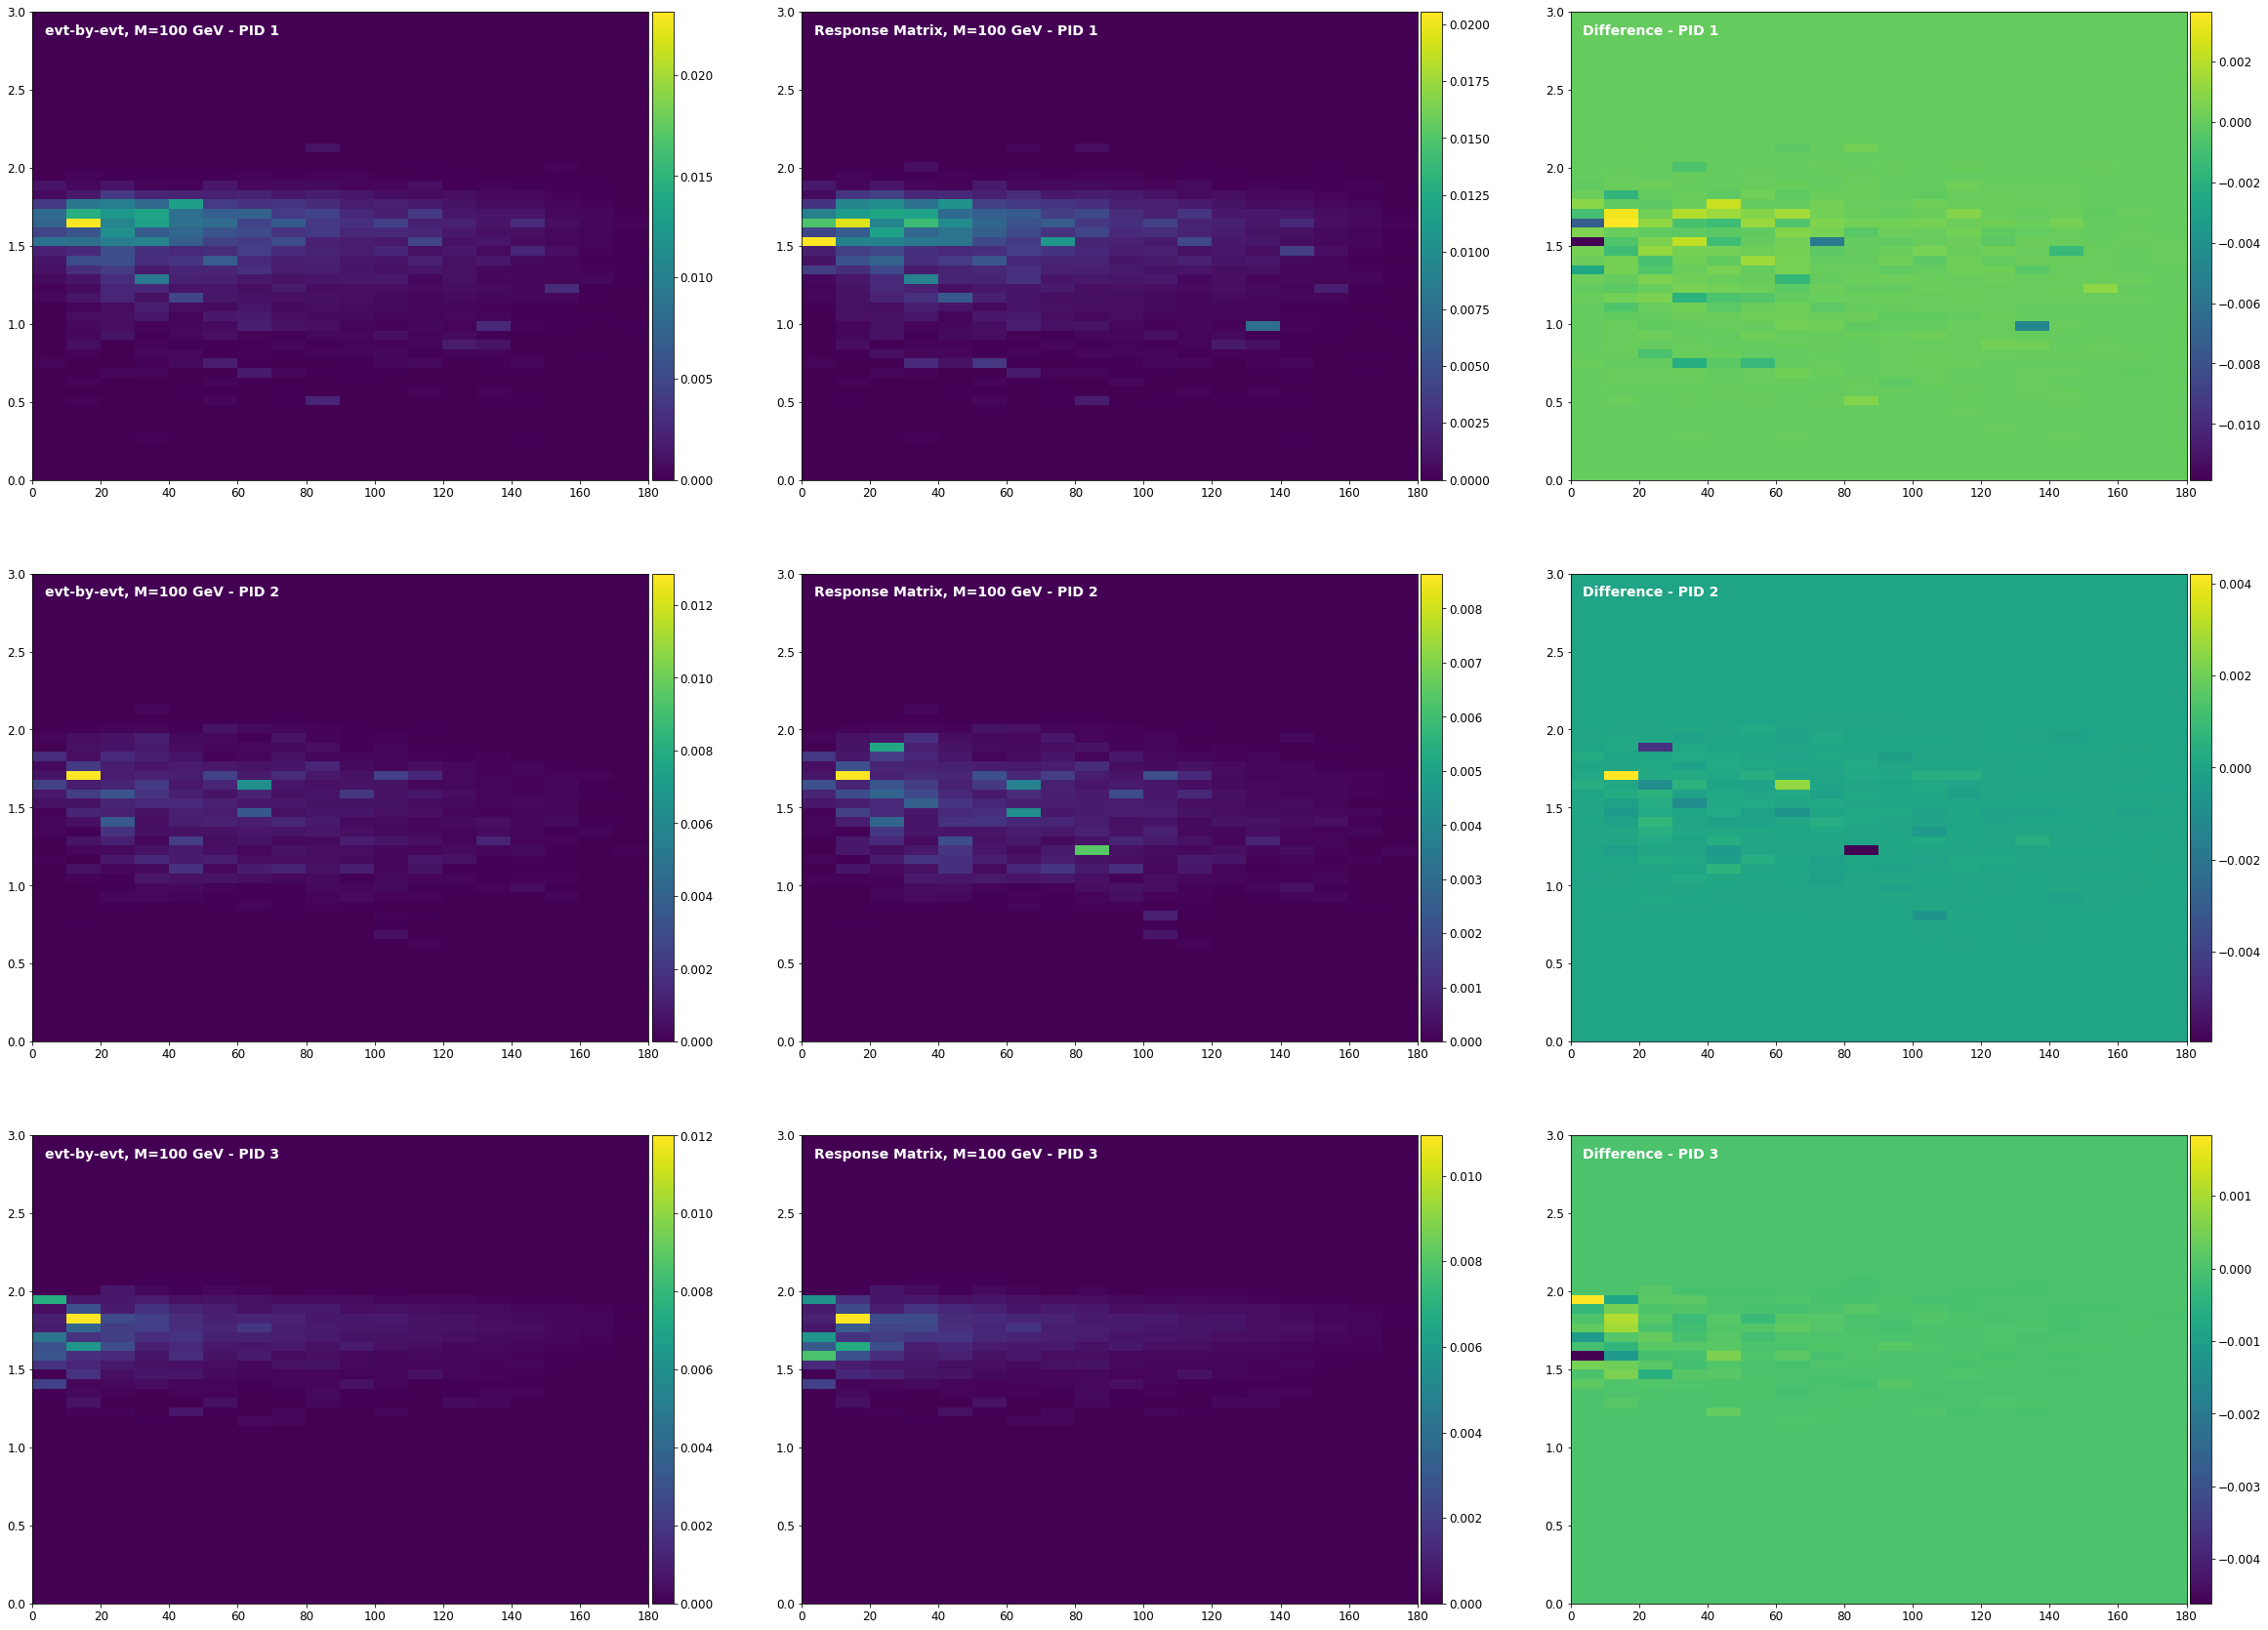

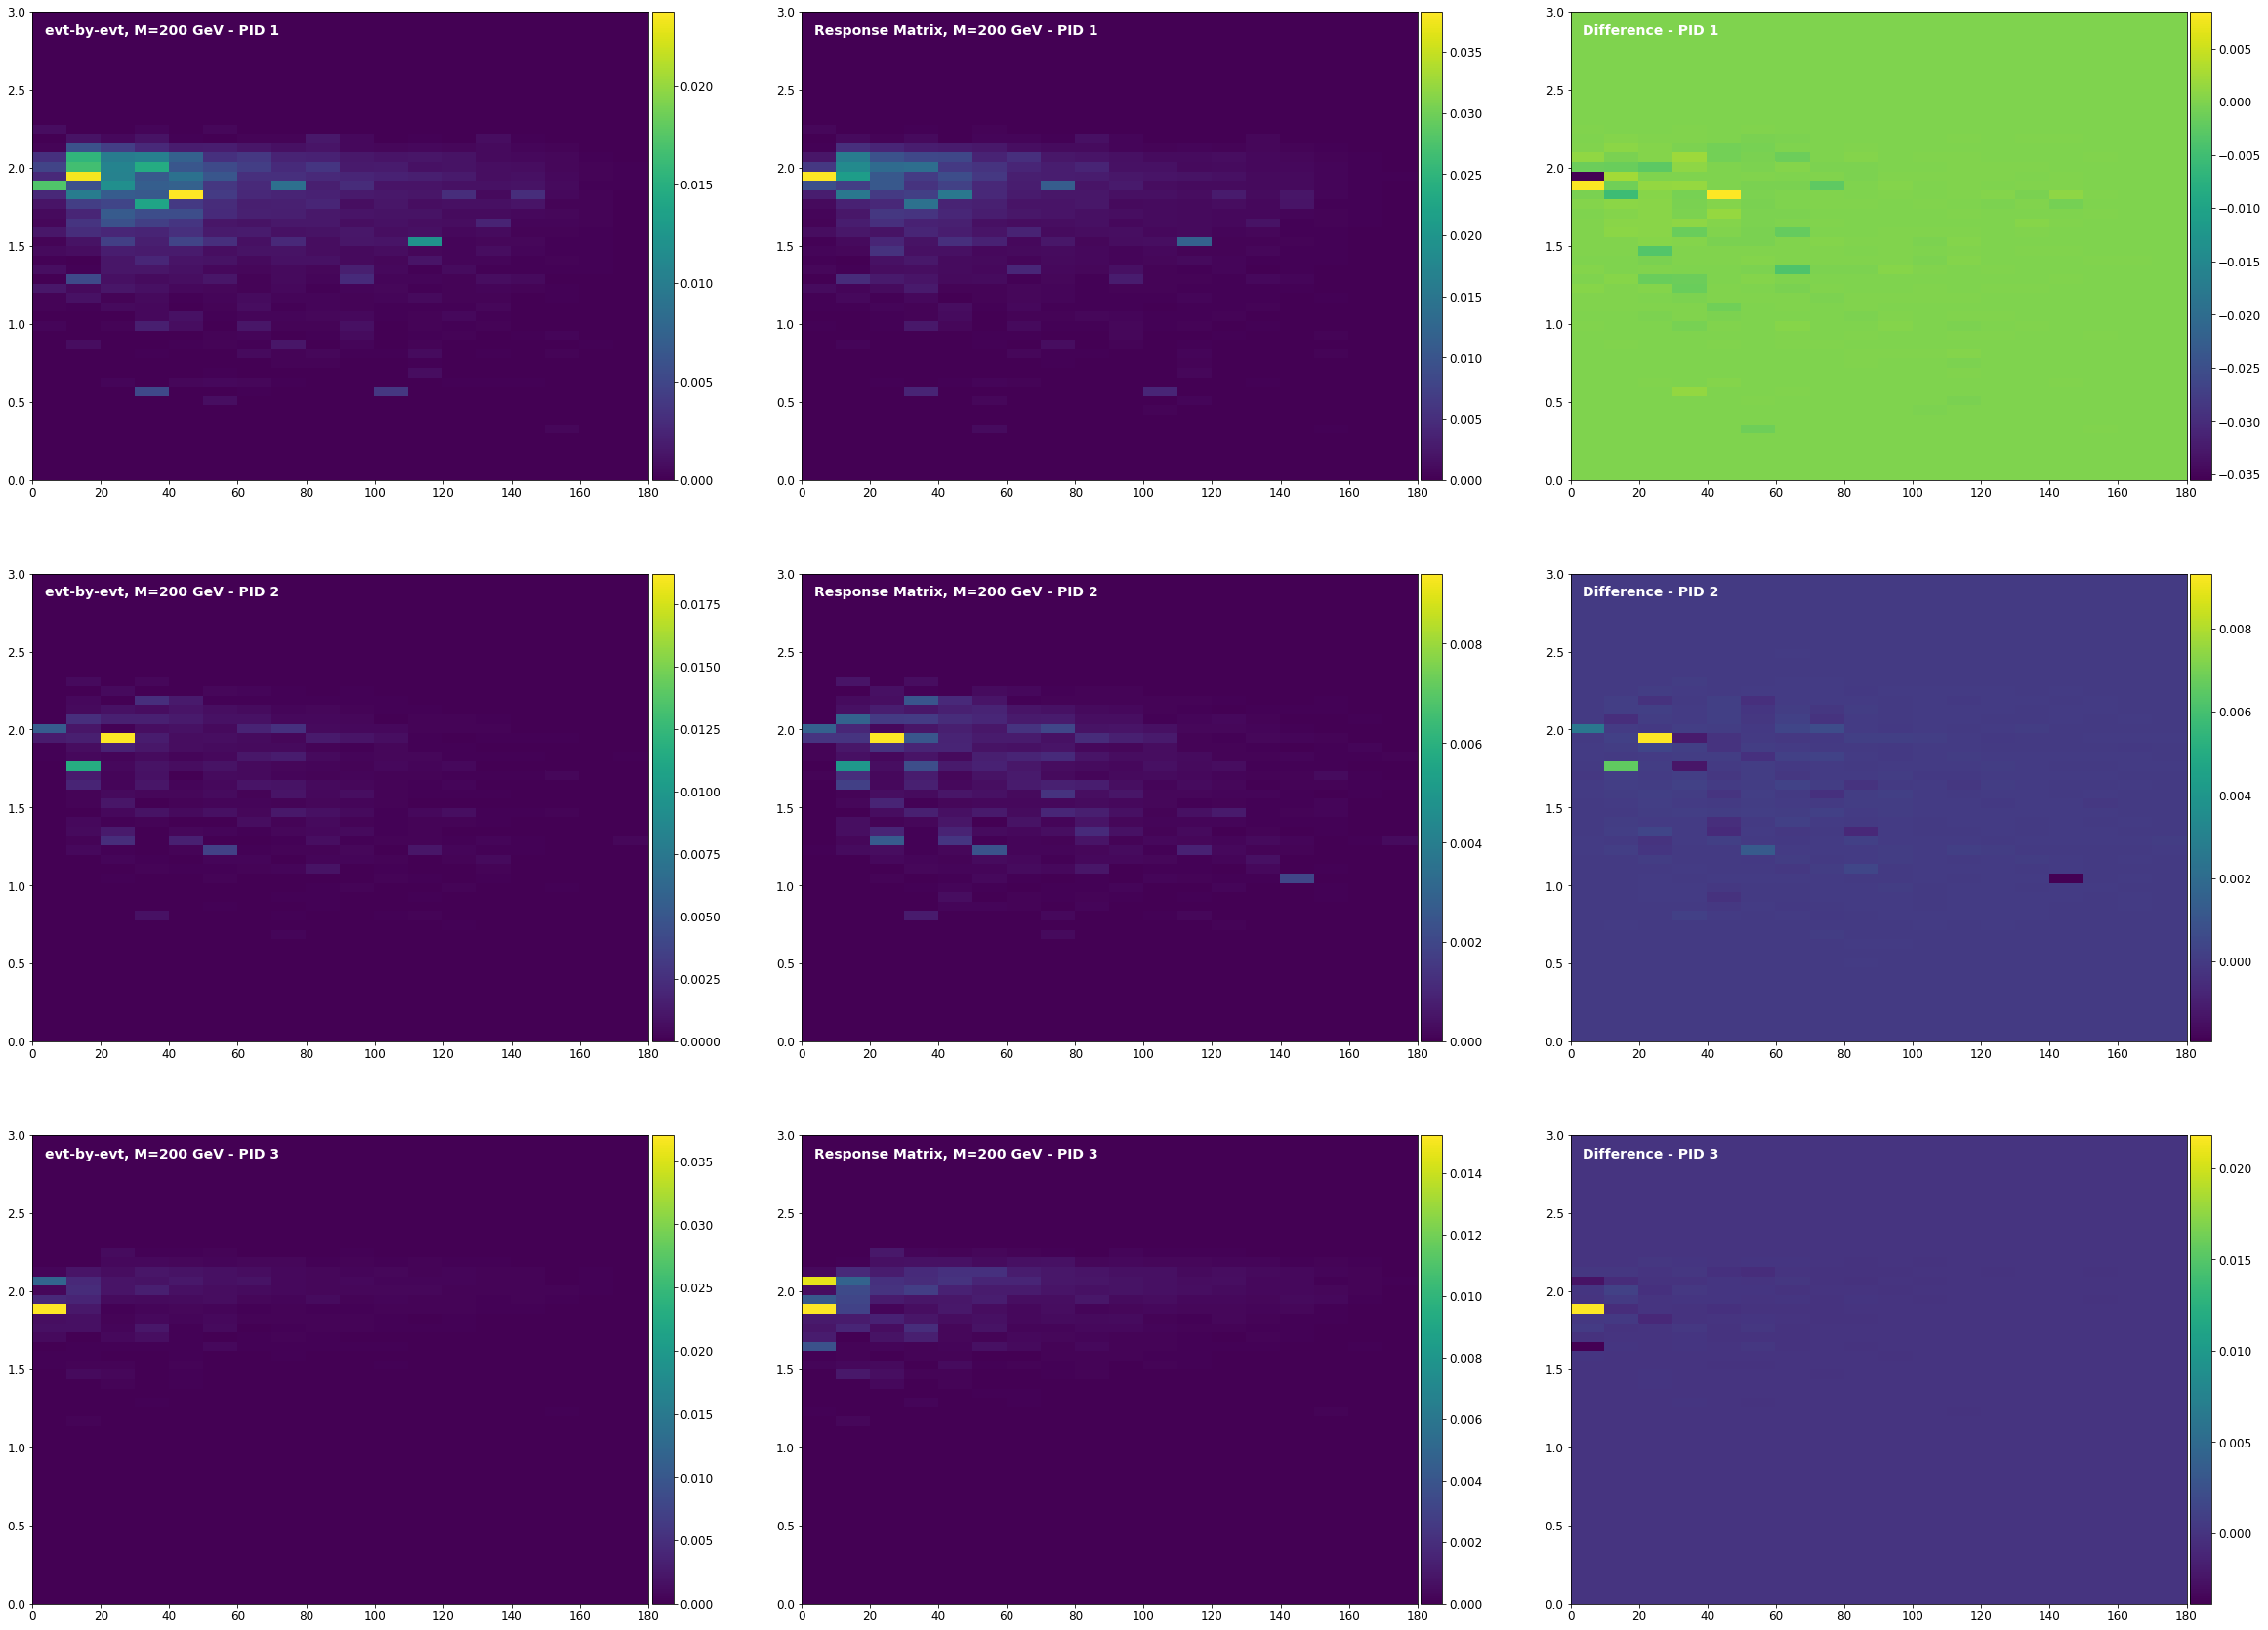

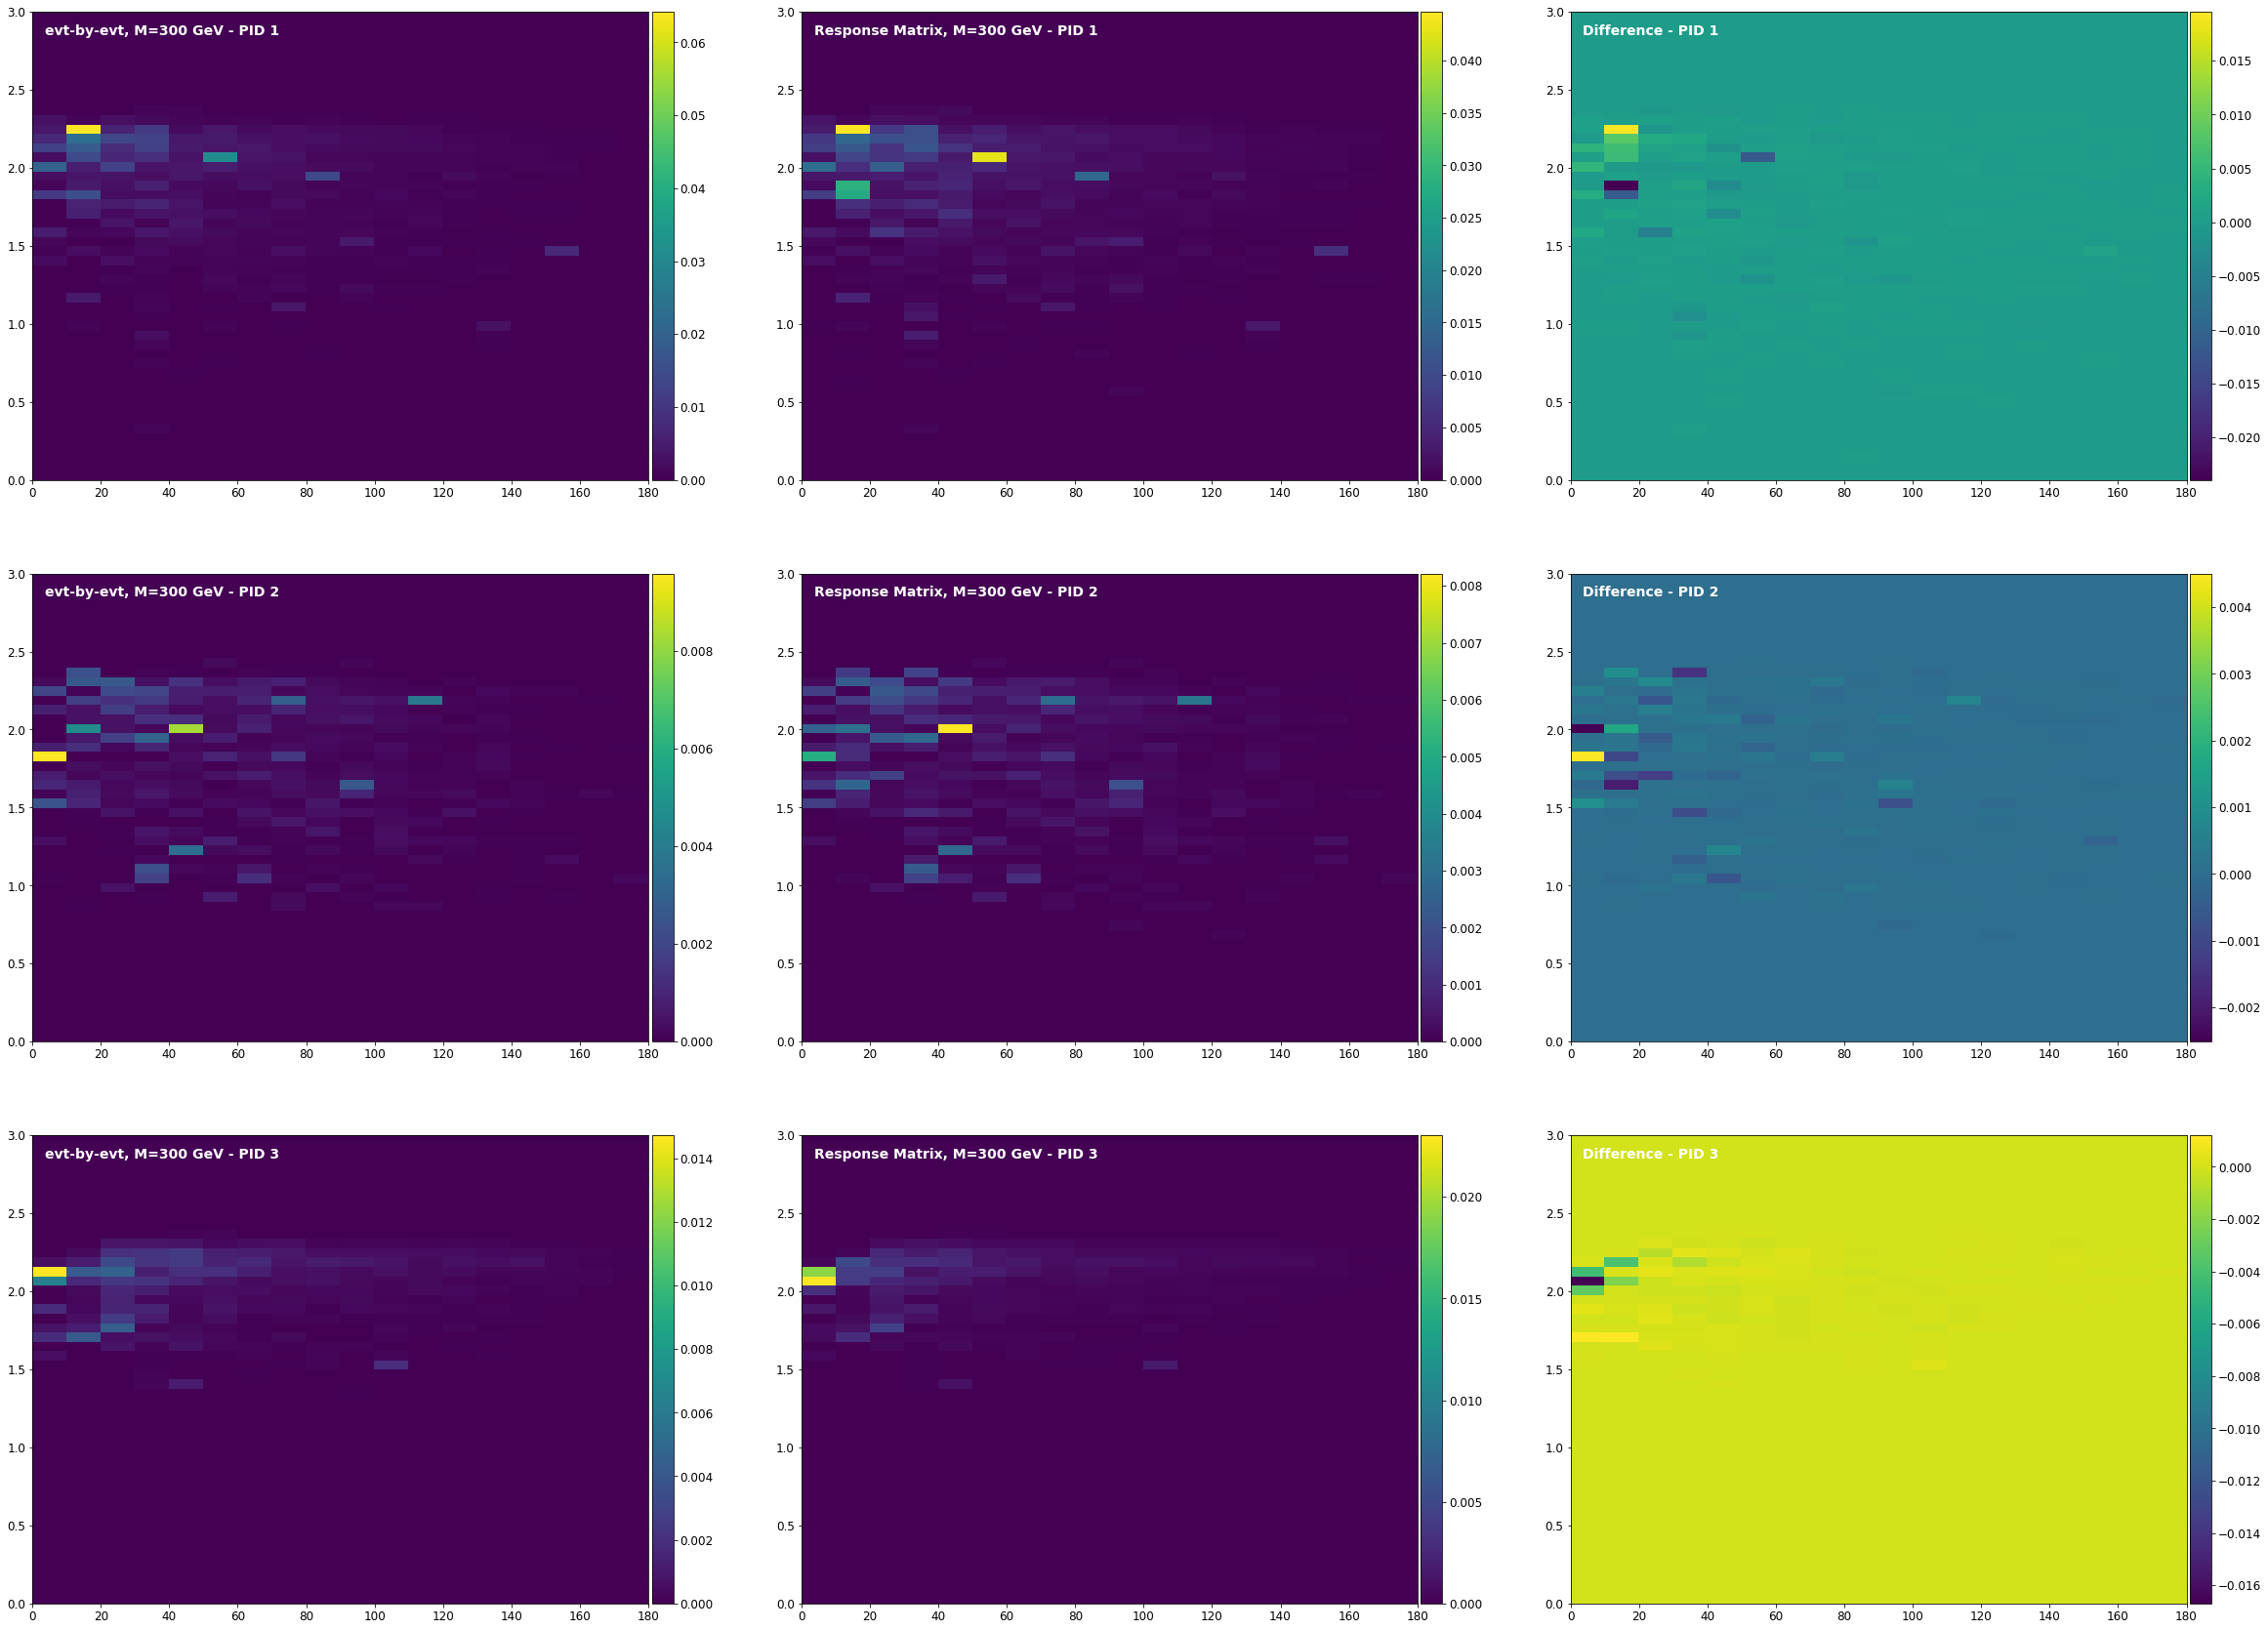

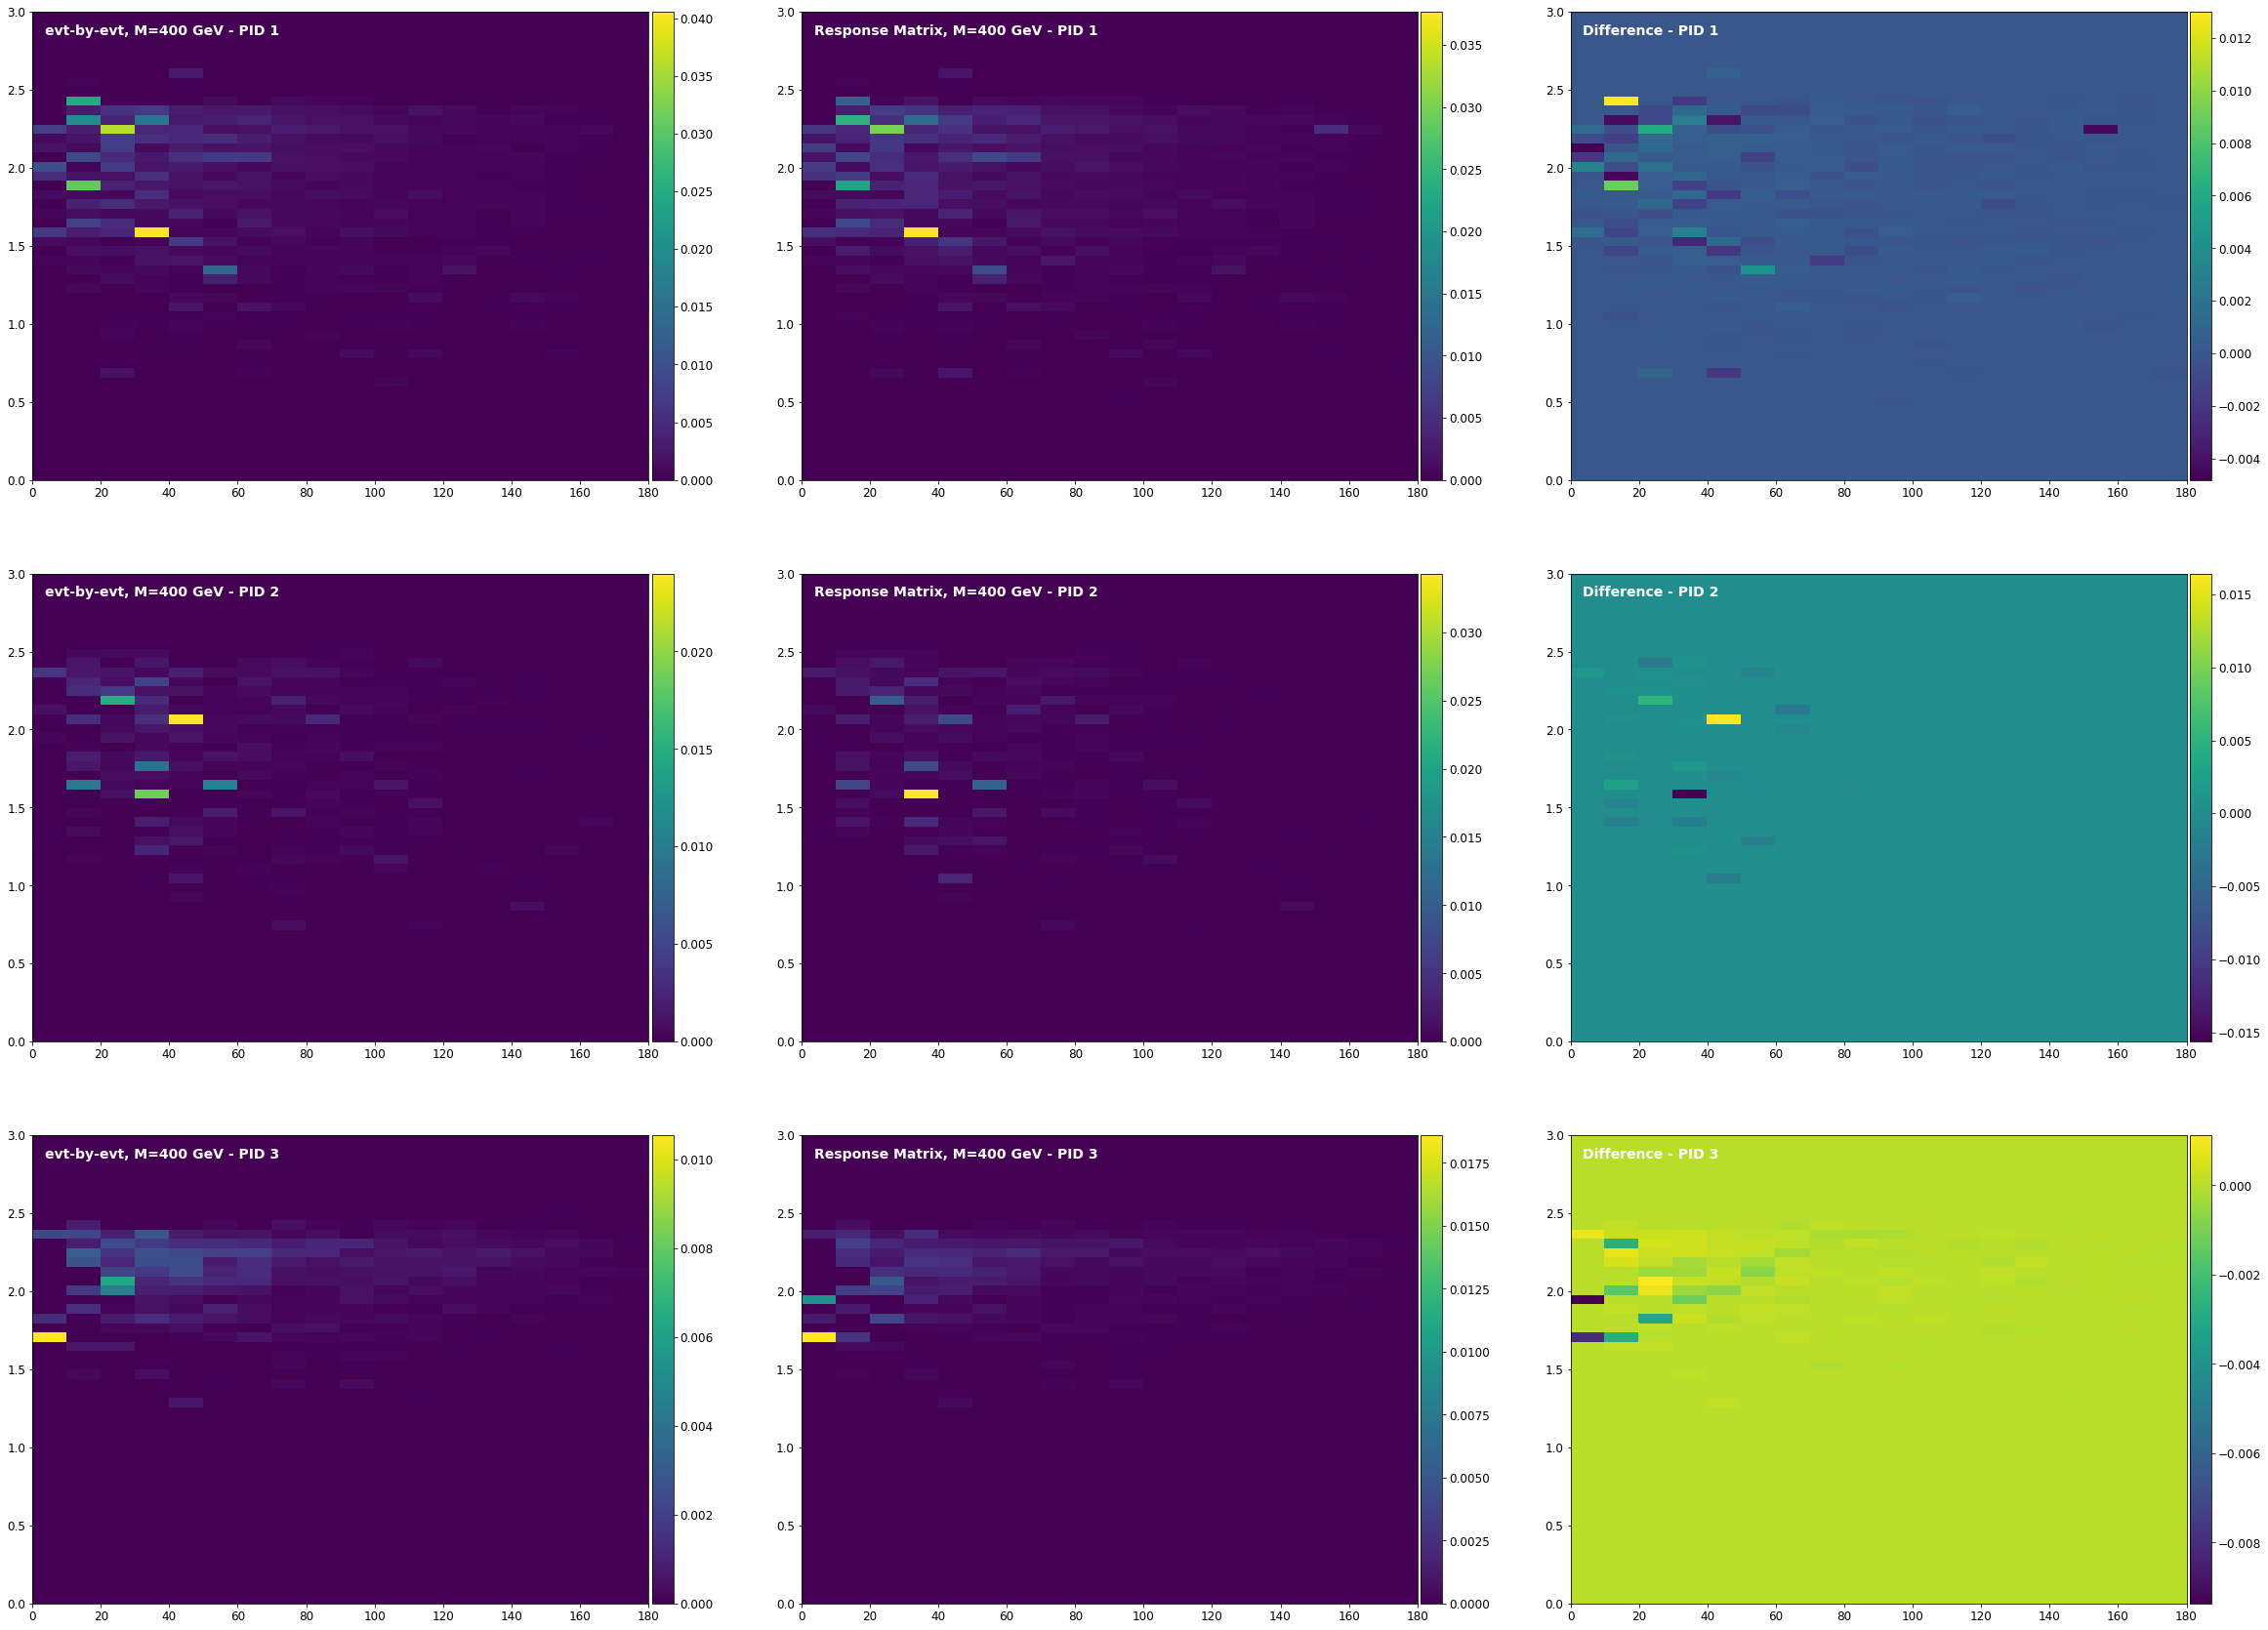

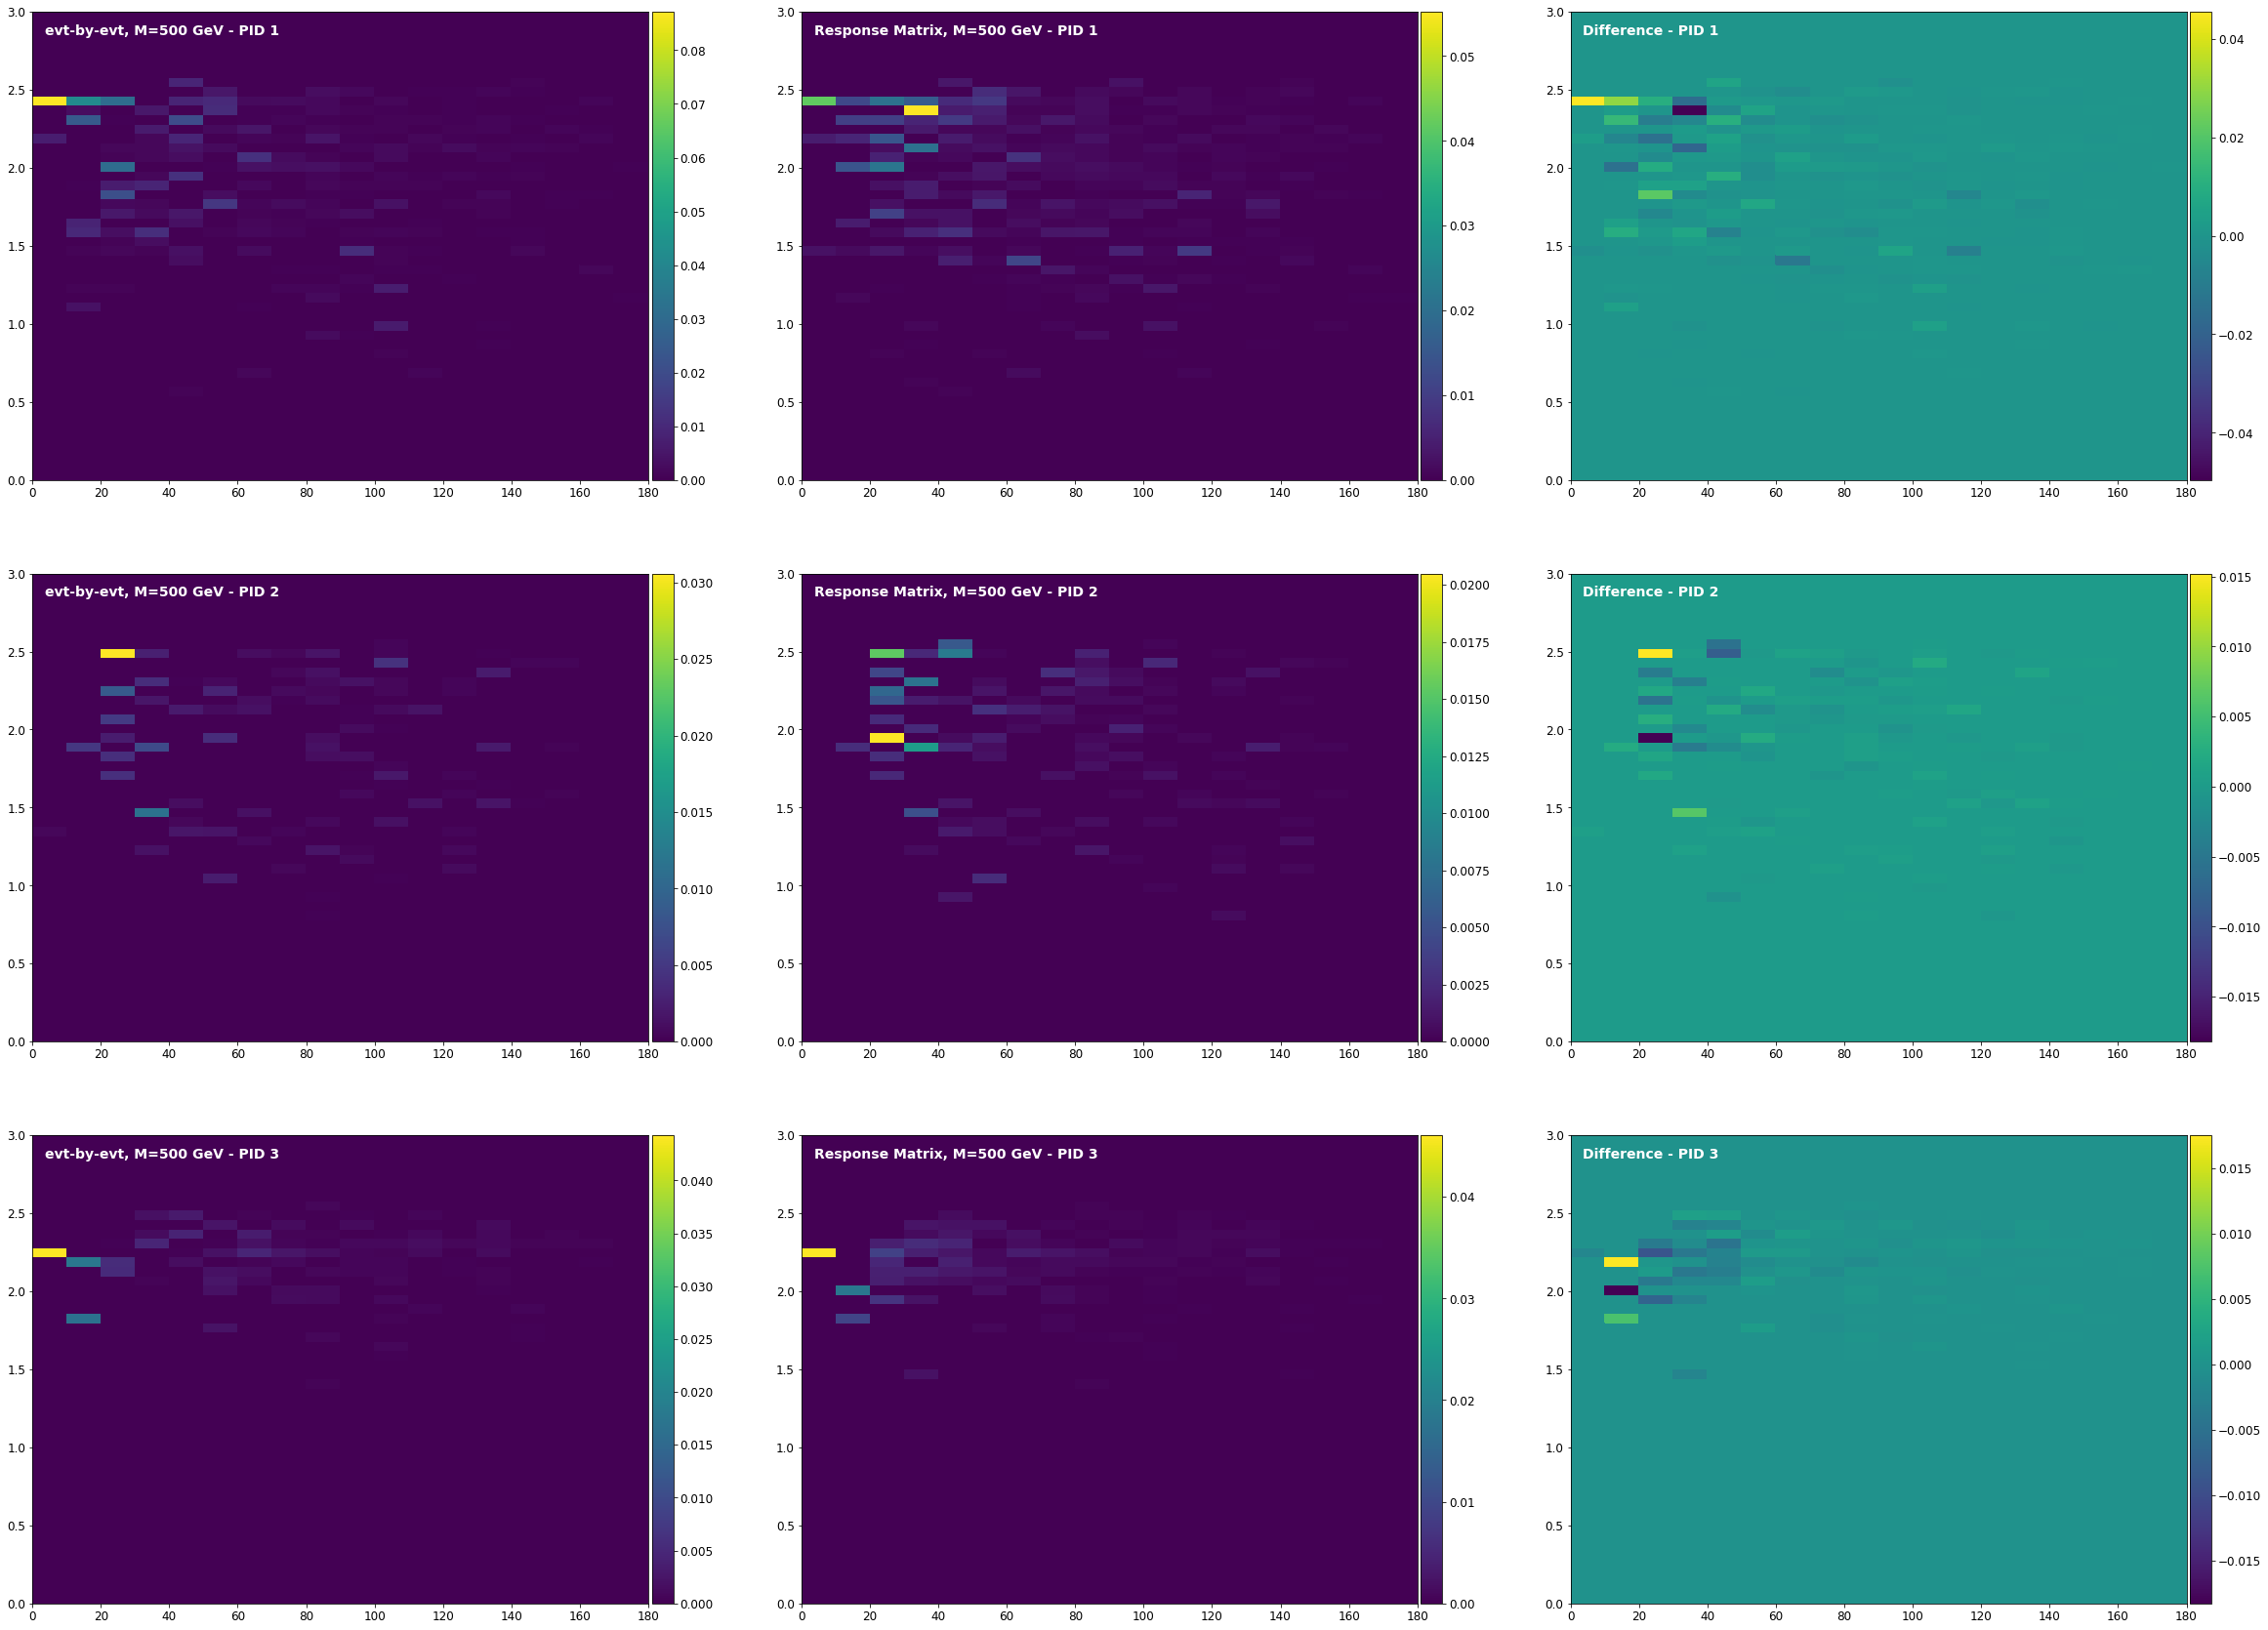

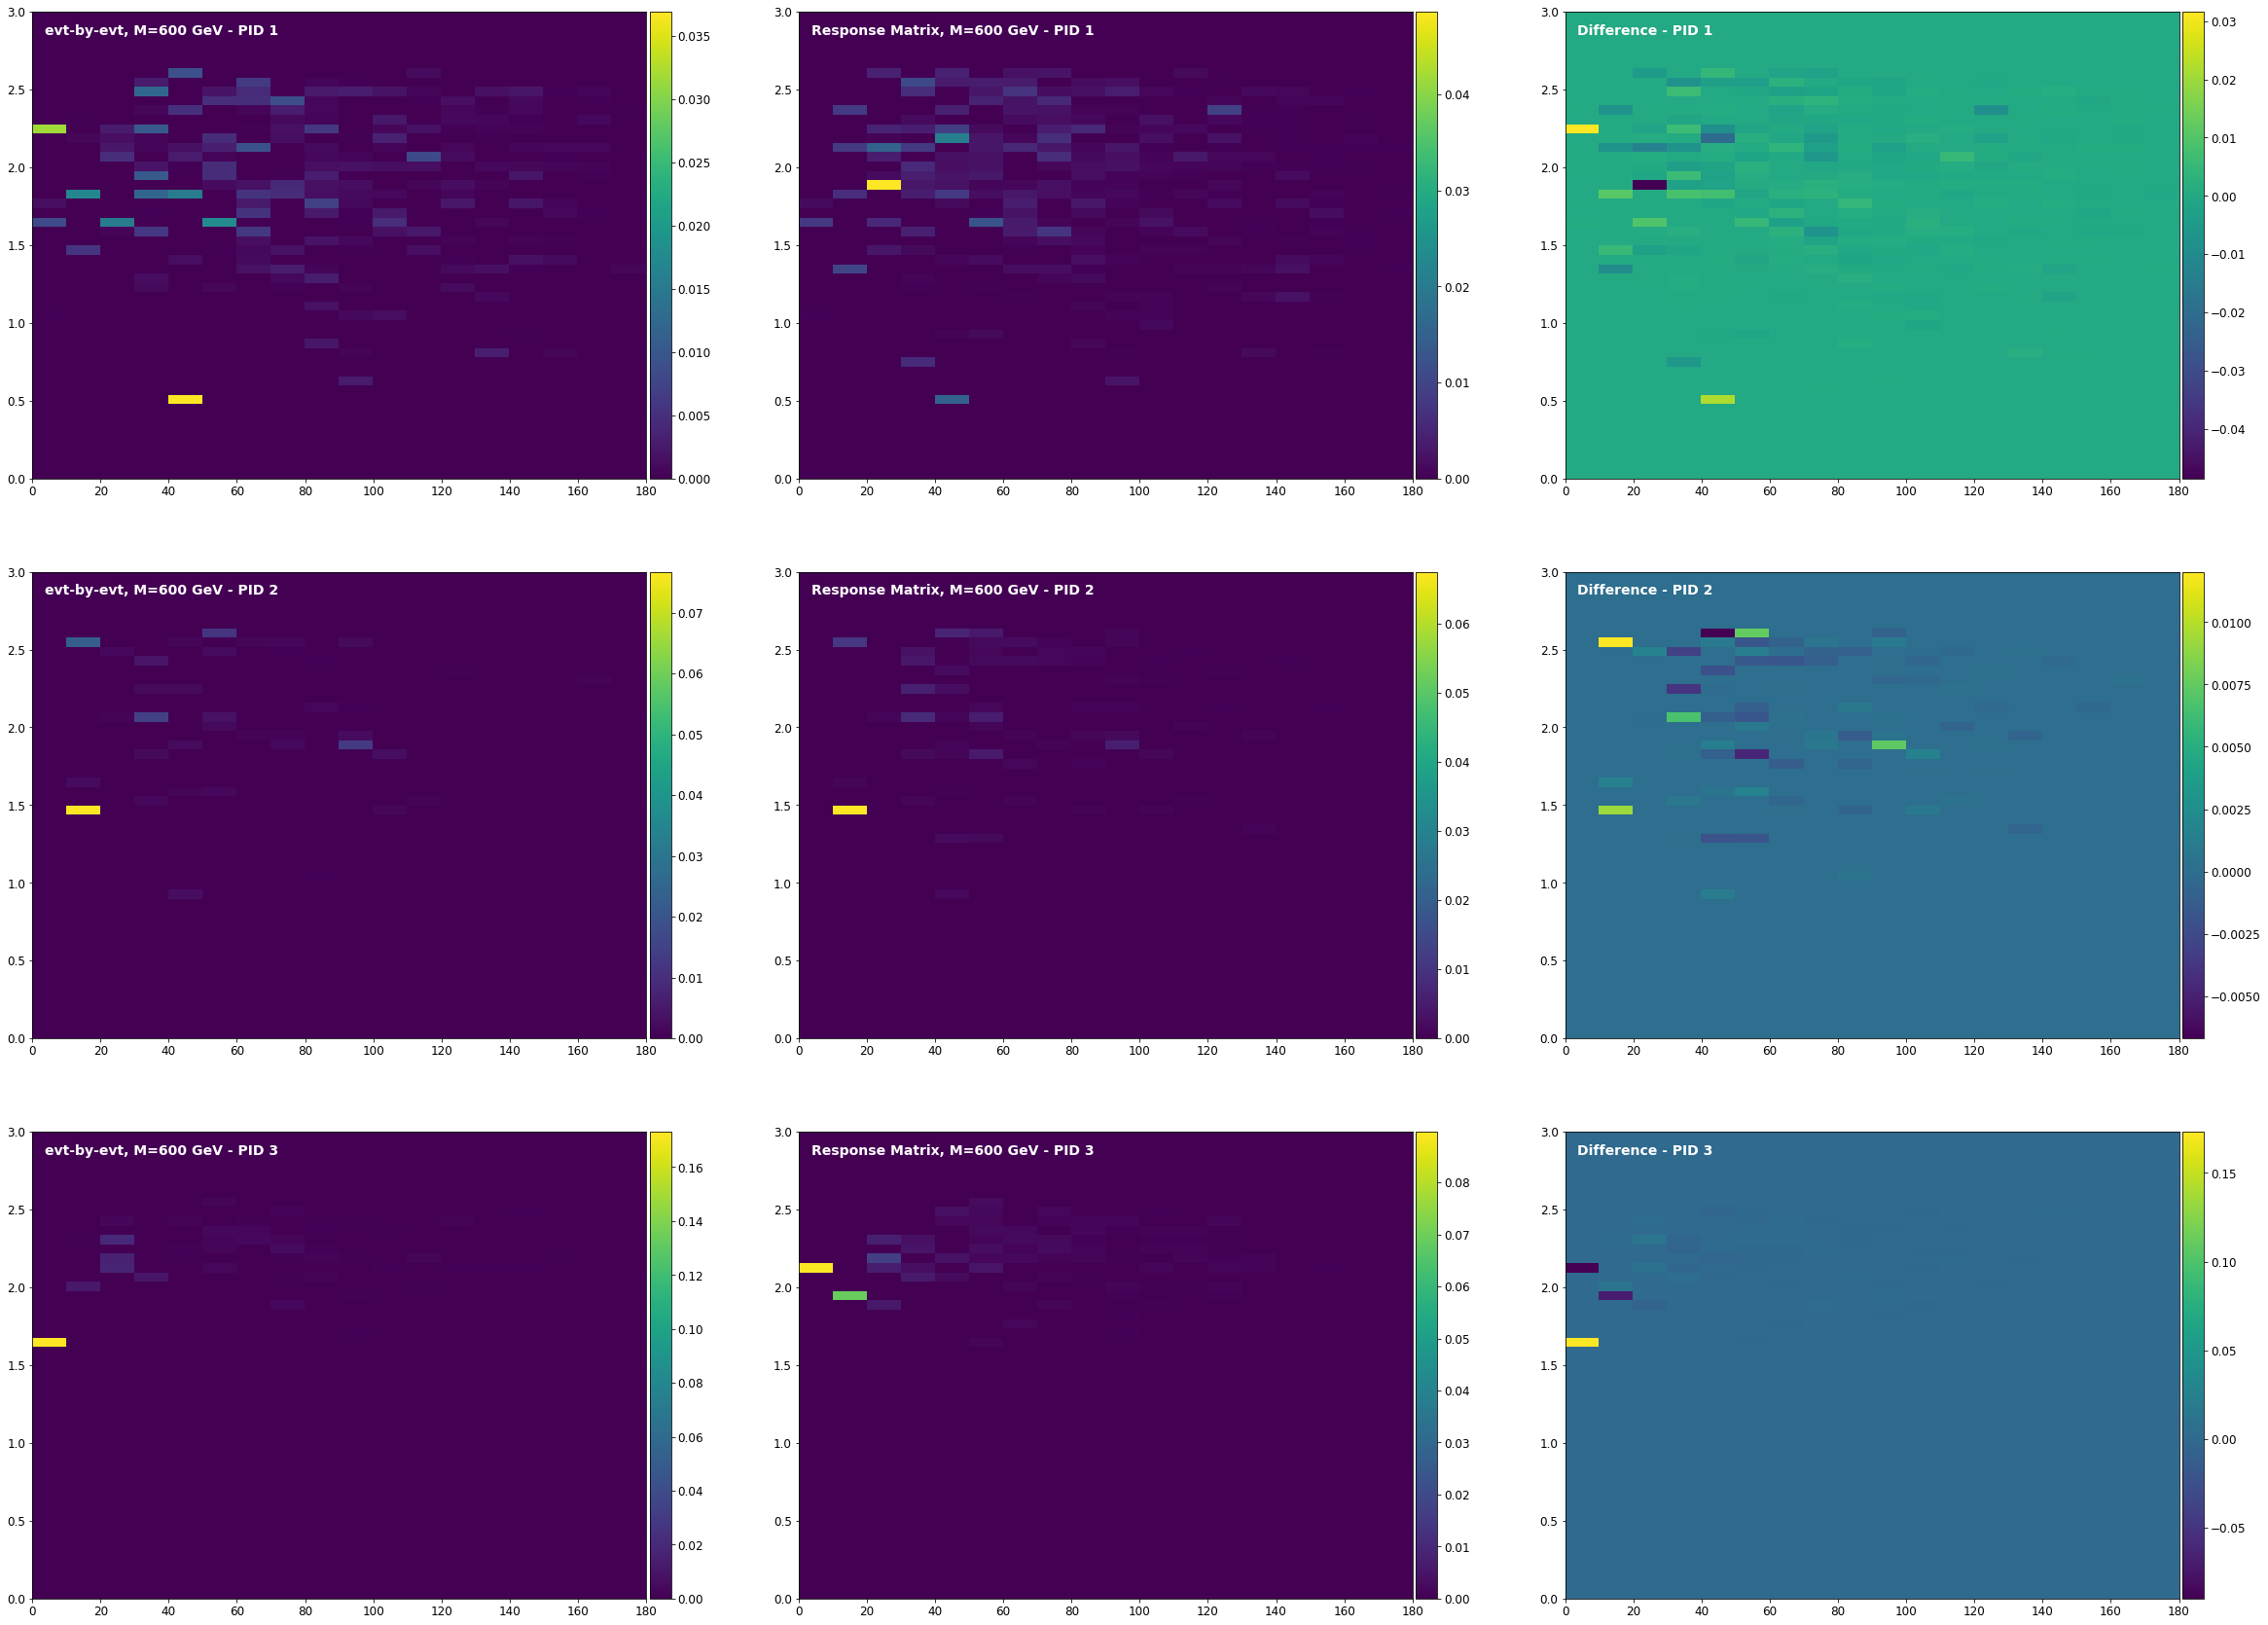

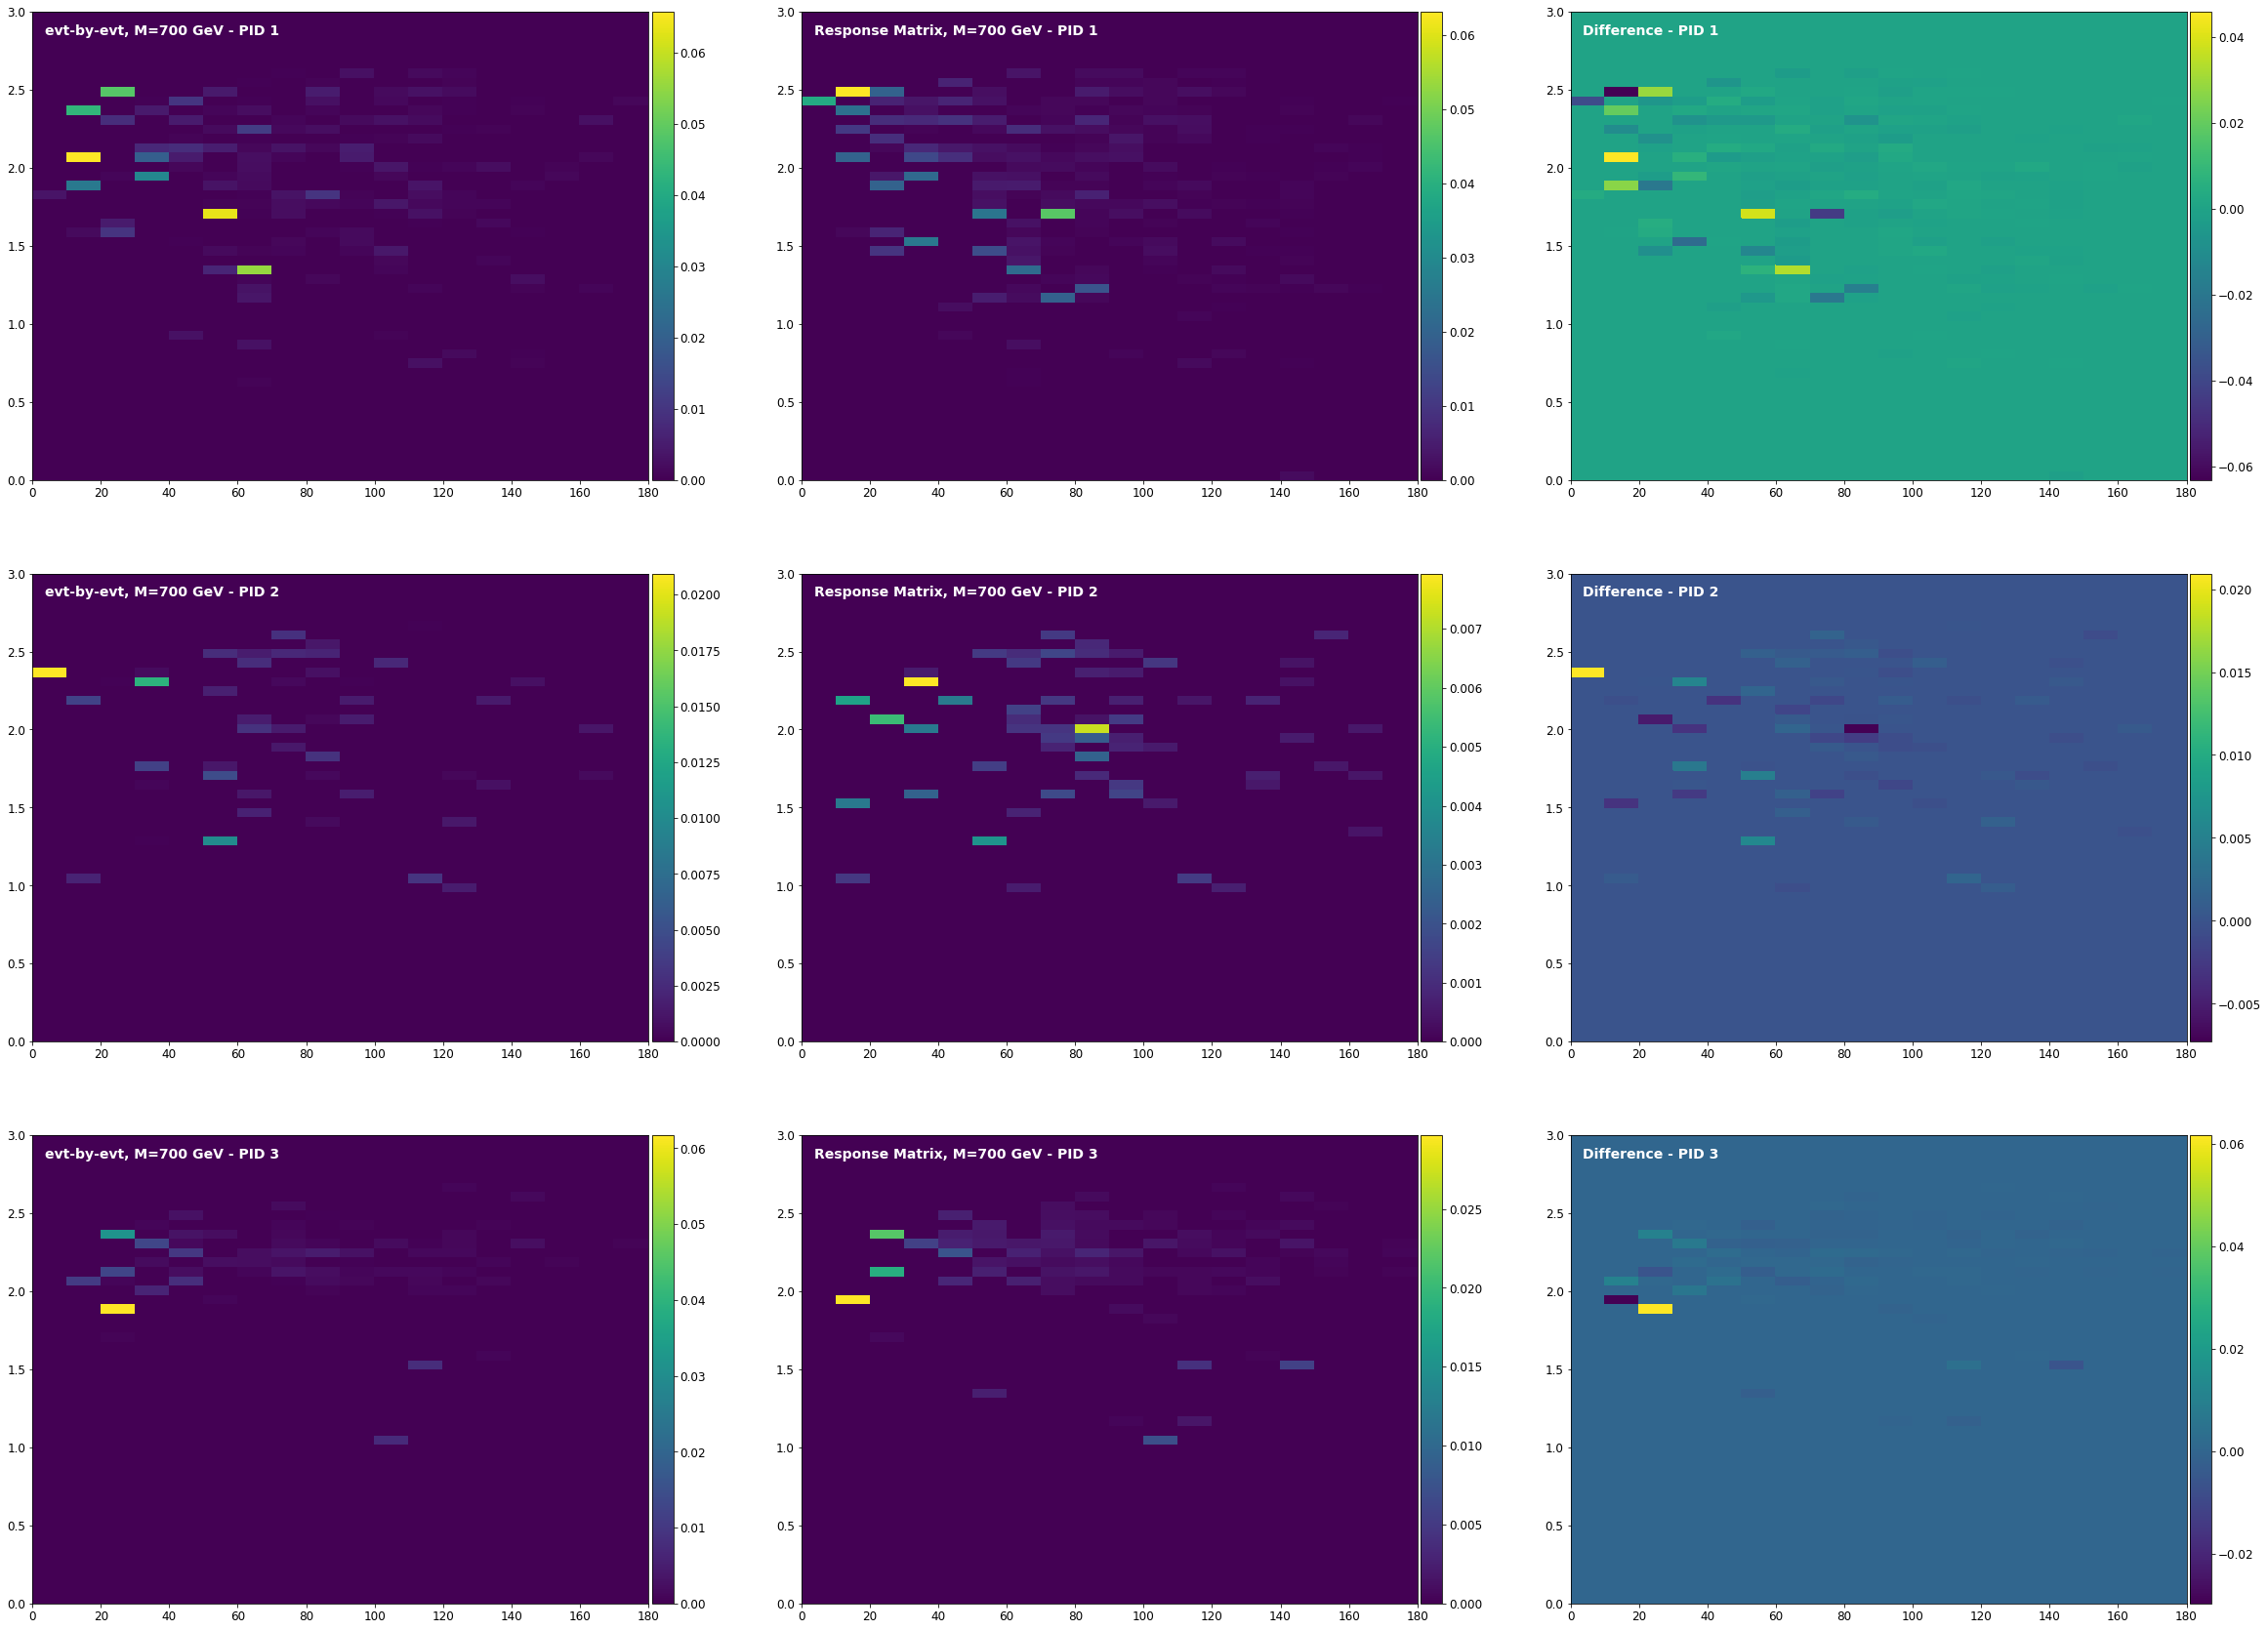

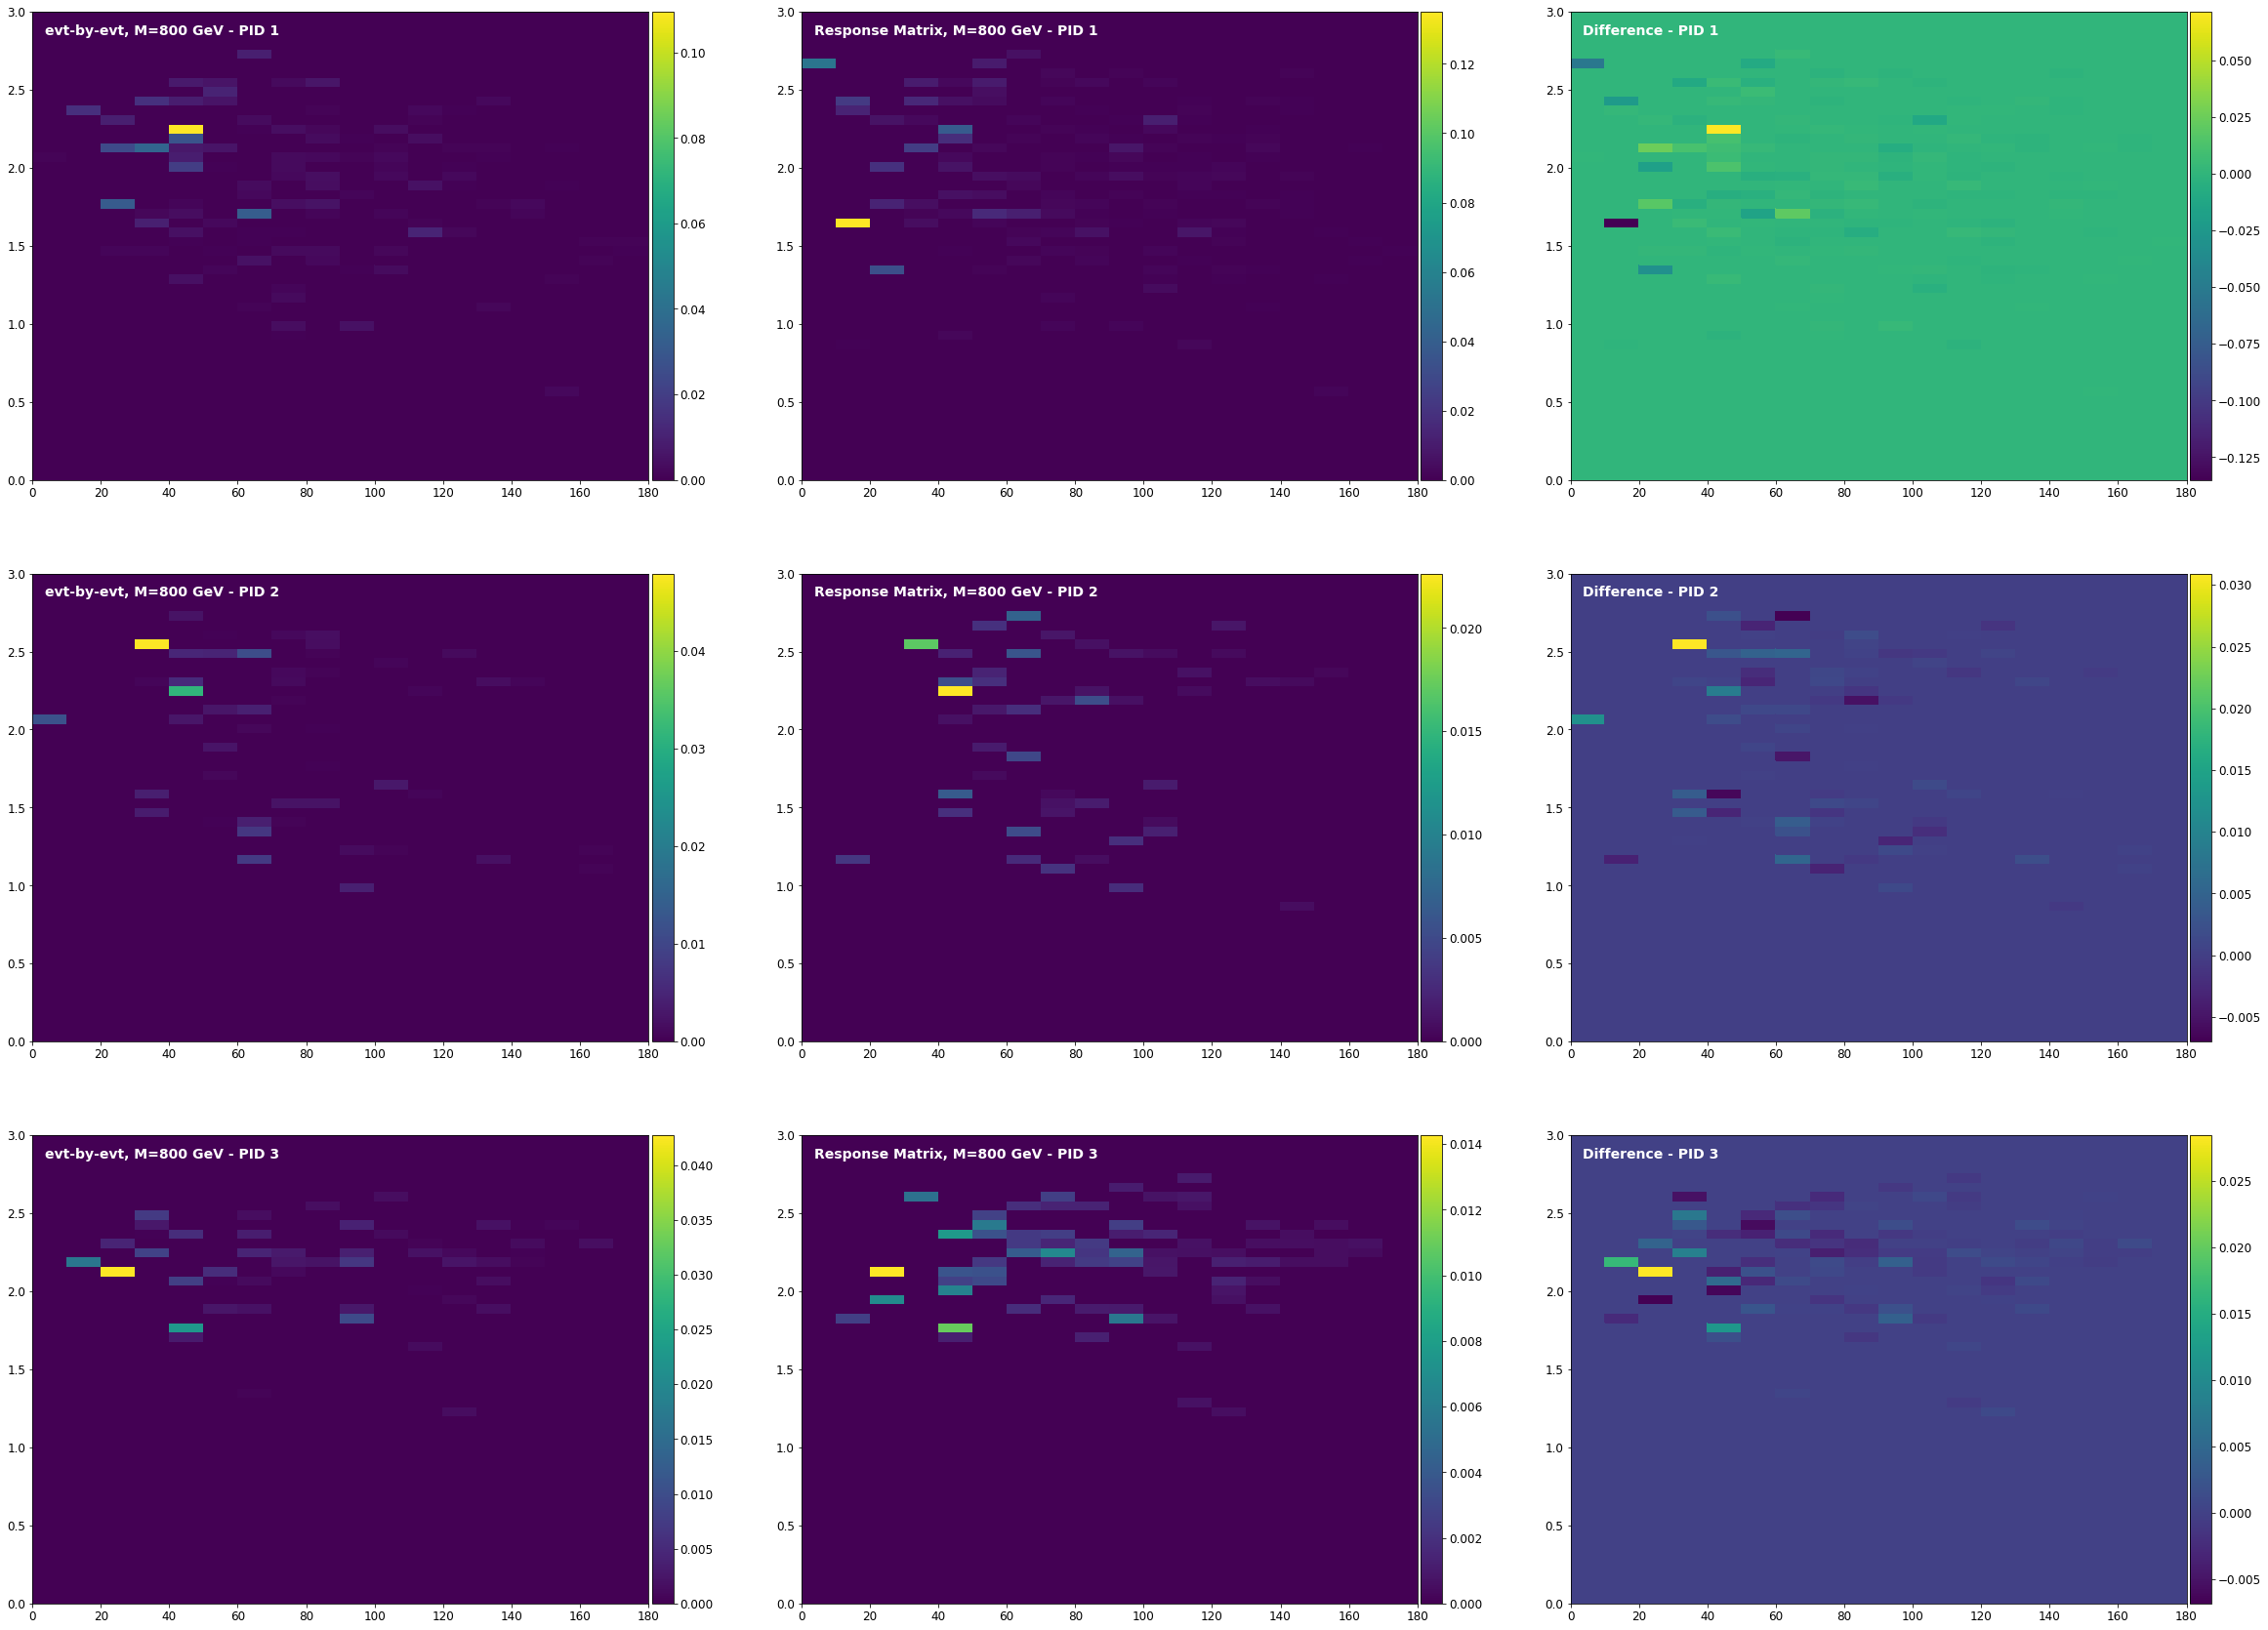

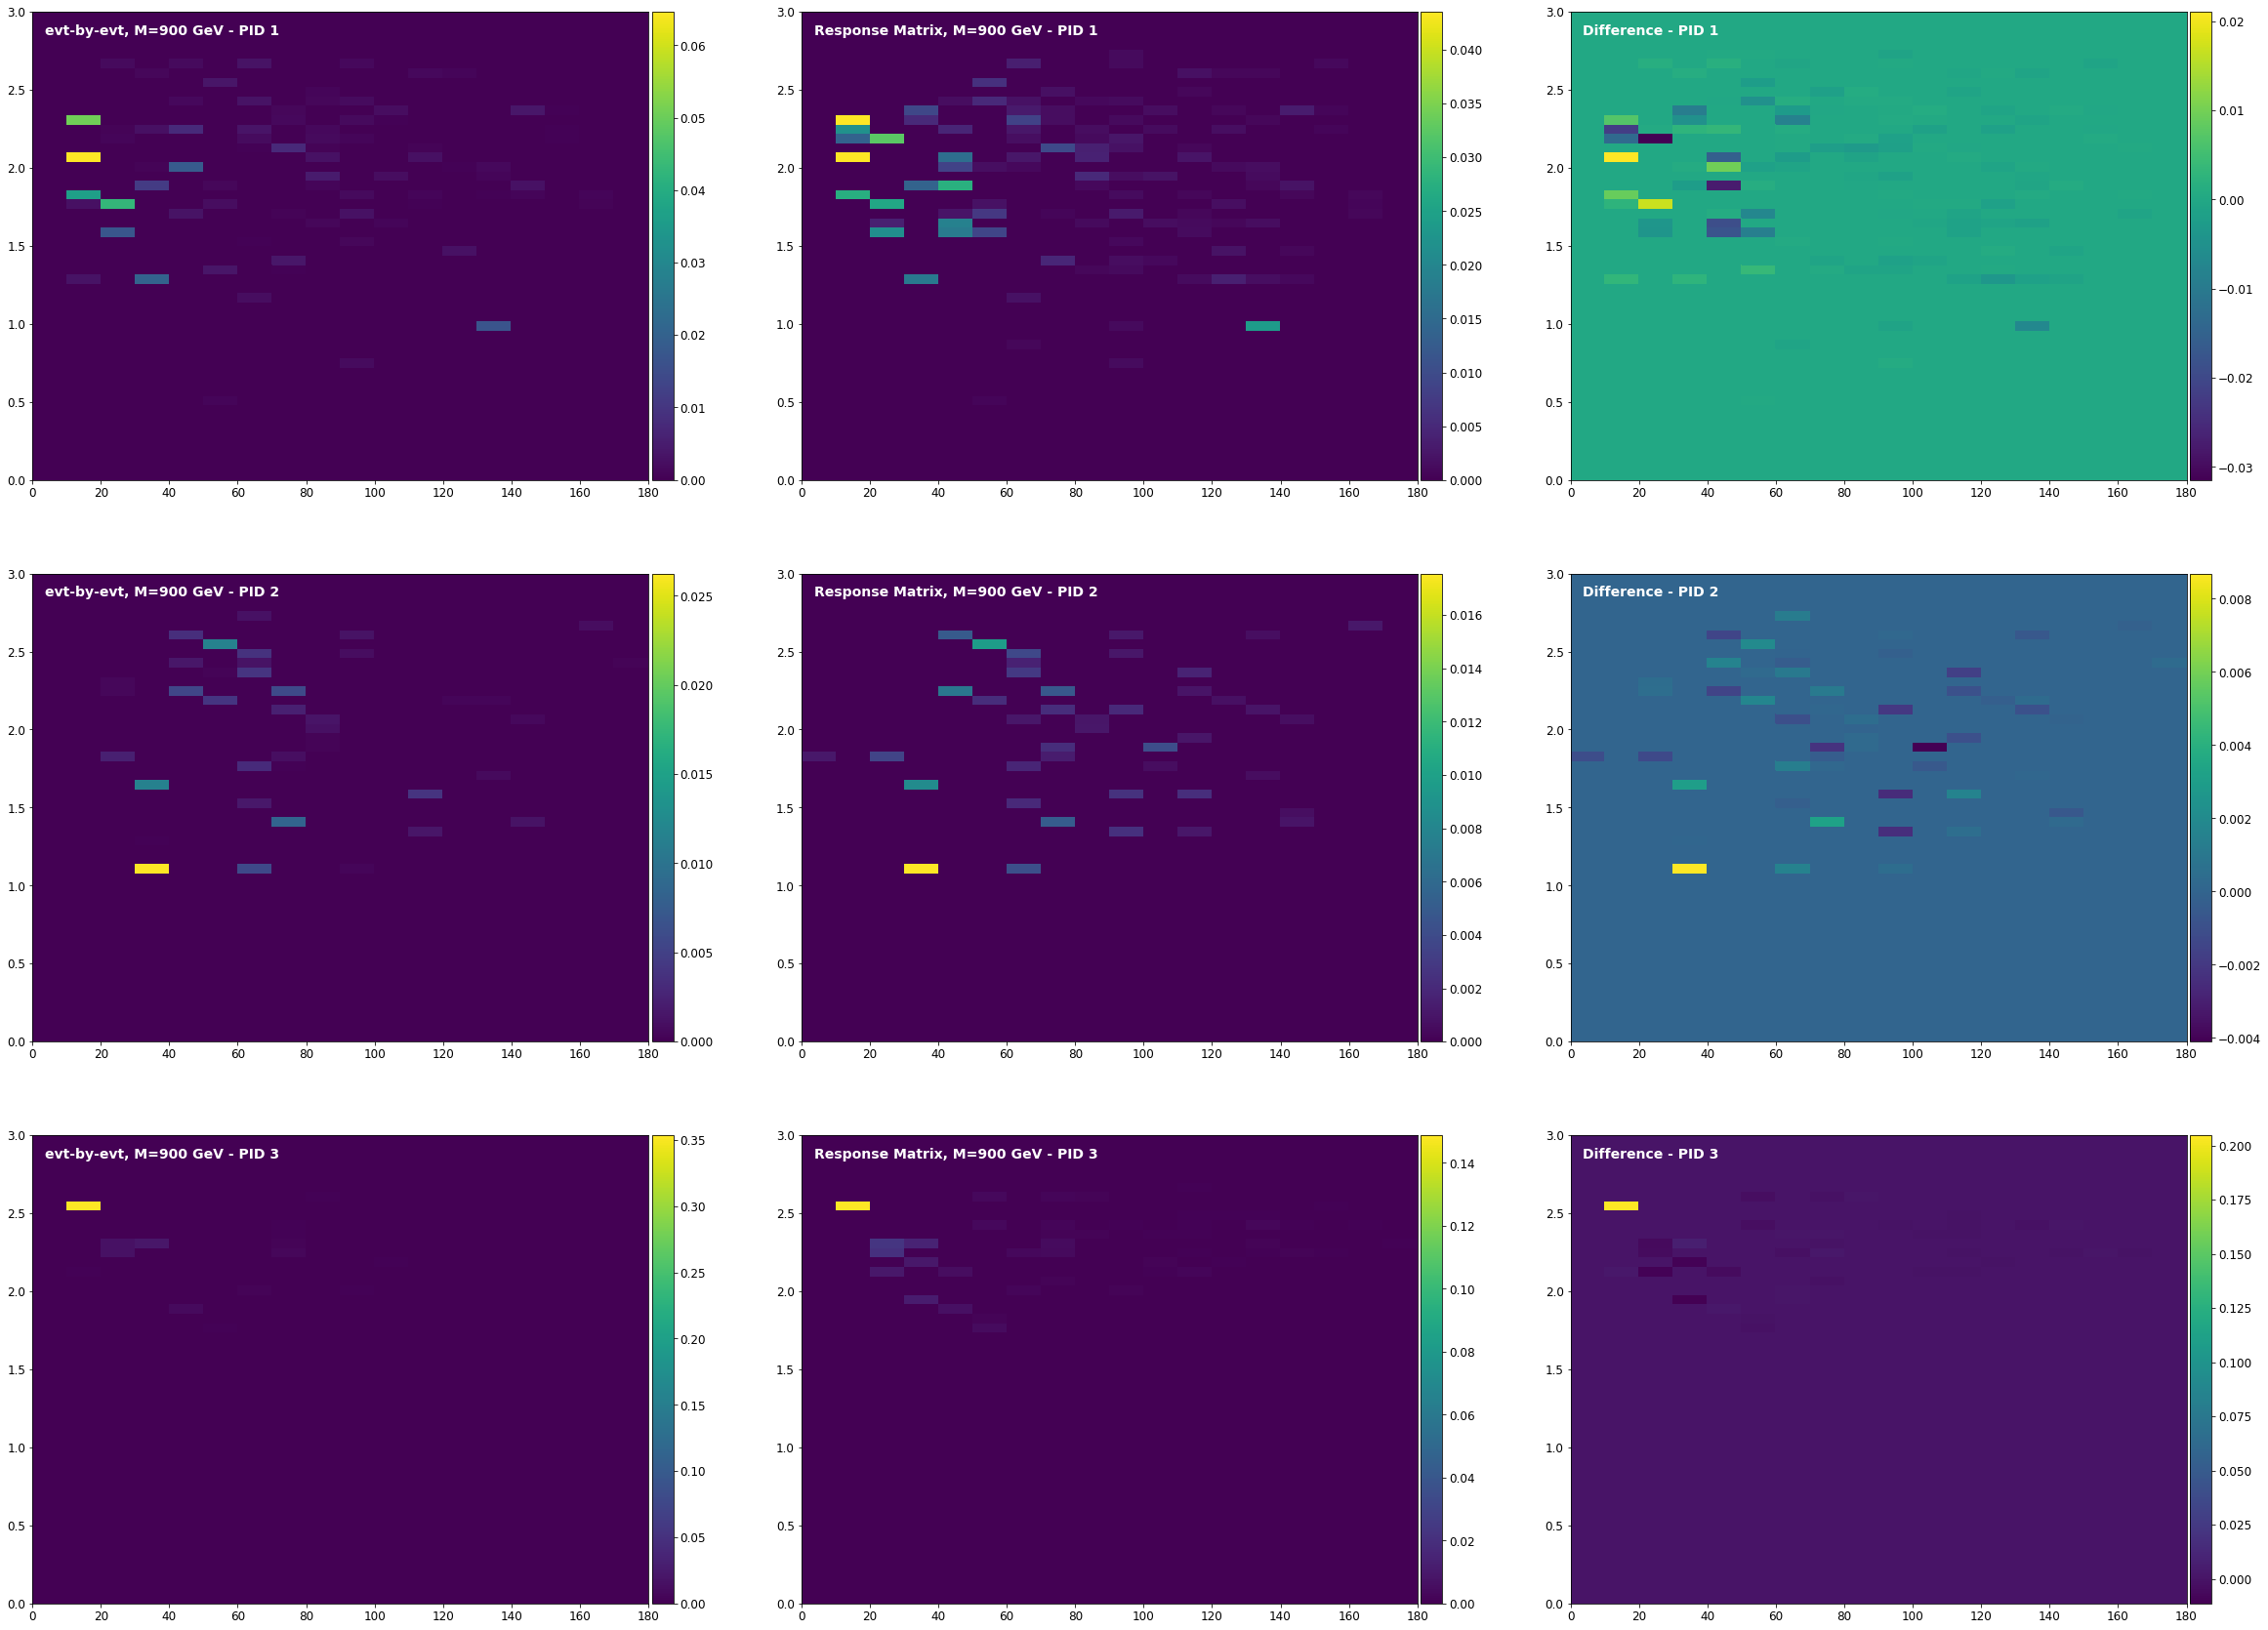

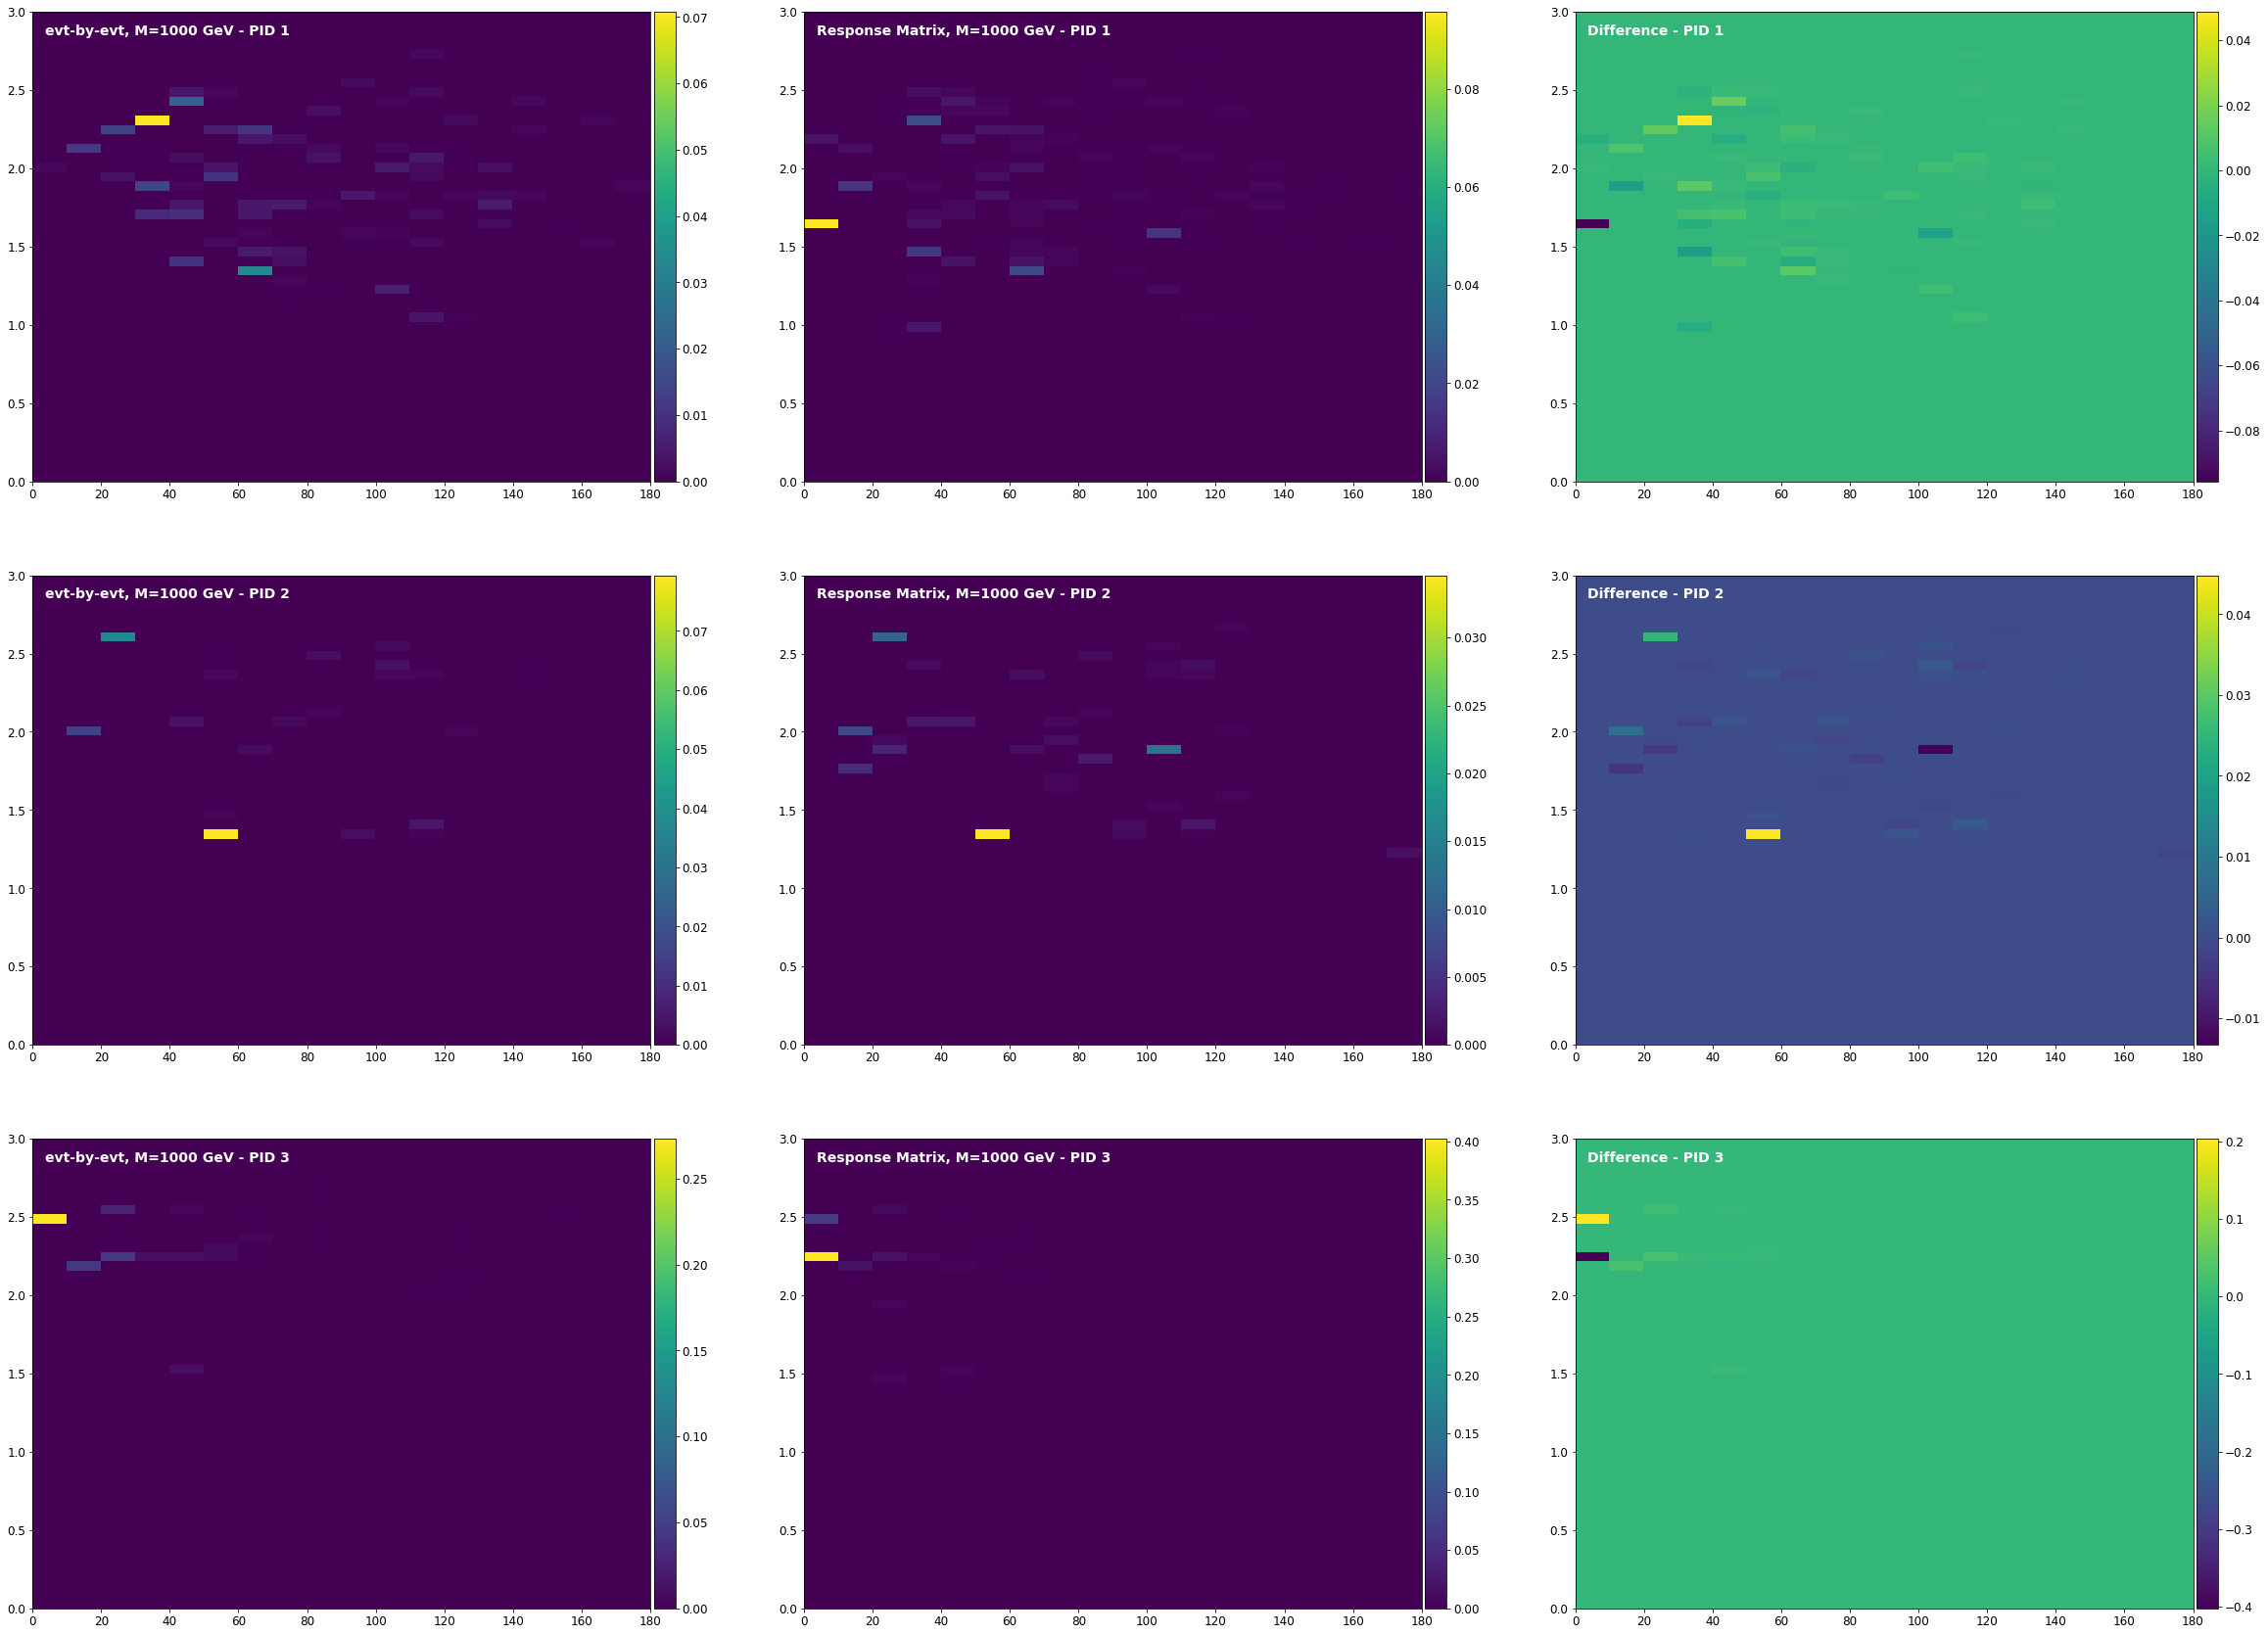

In [34]:
# Plot comparison for each masses:

for mass in masses:
    Plot2D_sidebyside_diff(PDF[mass]["evt"], PDF[mass]["resp"], [Resp['Bin']['reco_psi_edges'], 
                    np.log10(Resp['Bin']['reco_energy_edges'])], 
                    title1="evt-by-evt, M={} GeV".format(mass), title2="Response Matrix, M={} GeV".format(mass))
